In [1]:
# Change directory to the root folder of Dispa-SET:
import os
import sys
os.chdir('..')
import numpy as np
import pandas as pd
import datetime as dt
from dispaset.postprocessing import postprocessing as post
import importlib
importlib.reload(post)
%matplotlib inline
#Import Dispa-SET
import dispaset as ds
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import matplotlib.dates as mdates
#plt.style.use('seaborn-colorblind')
import pickle
import time as tm
import logging
import matplotlib


In [30]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 8]

In [31]:
pd.options.display.max_rows = 60   #default 60 (None)
pd.options.display.max_columns = 60   #default 60 (None)
np.set_printoptions(threshold=np.inf)   #default 1000 (np.inf)

In [32]:
try:
    import cPickle as pickle
except ImportError:
    import pickle

In [33]:
def FindNetPowerFlow(PowerFlow):
    NewOutputFlow = PowerFlow.copy()
    OriginalColumns = []
    reverseindex = []
    for j,column in enumerate(NewOutputFlow):
        A = column.split(' -> ')
        OriginalColumns.append(A)
        B = list(reversed(A))
        if B in OriginalColumns:
            reverseindex.append(j)
            D = [i for i, C in enumerate(OriginalColumns) if C==B]
            D = int(''.join(map(str,D)))
            NewOutputFlow.iloc[:,D] = NewOutputFlow.iloc[:,D] - NewOutputFlow.iloc[:,j]
    NewOutputFlow = NewOutputFlow.drop(NewOutputFlow.columns[reverseindex], axis=1).copy()
    return NewOutputFlow

In [34]:
def FindUniquePowerExchange(PowerExchange):
    NewPowerExchange = PowerExchange.copy()
    Combinations = []
    reverseindex = []

    for zone1 in NewPowerExchange.columns.unique(level=0):
        for zone2 in NewPowerExchange.columns.unique(level=1):
            if zone1!=zone2:
                List = [zone1,zone2]
            if List not in Combinations:
                try:
                    NewPowerExchange.drop((zone2,zone1), axis = 1, inplace = True)
                except:
                    pass
                Combinations.append(List)
                Combinations.append(list(reversed(List)))
    return NewPowerExchange

In [35]:
def FindCountryExchange(PowerExchange, InternalZones, ExternalZones):
    CountryExchange = 0
    for internalzone in InternalZones:
        for externalzone in ExternalZones:
            try:
                CountryExchange += PowerExchange[internalzone][externalzone]
            except:
                pass
    return CountryExchange

In [36]:
def FindAverageElectricityCostPlusKSA(Demand, TotalNodeOperationCost, DropKSAZones = True):

    A = pd.Series((Demand.sum().drop(['BA','KW','OM','QA','UAE'])).sum())
    A.name = 'KSA'
    System_demand = pd.DataFrame(Demand.sum())
    System_demand = System_demand.append(A, ignore_index = False)
    if DropKSAZones:
        System_demand = System_demand.drop(index = ['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA'])
    System_demand.columns = ['TotalDemand']
        
    A = pd.Series((TotalNodeOperationCost.sum()).drop(['BA','KW','OM','QA','UAE']).sum())
    A.name = 'KSA'
    SystemCost = pd.DataFrame(TotalNodeOperationCost.sum())
    SystemCost = SystemCost.append(A, ignore_index = False)
    if DropKSAZones:
        SystemCost = SystemCost.drop(index=['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA'])
    SystemCost.columns = ['SystemCost']

    ElectricityCost = pd.Series(SystemCost['SystemCost'], index = SystemCost.index)/pd.Series(System_demand['TotalDemand'], index=System_demand.index)
    return ElectricityCost

In [37]:
def FindAverageElectricityCostPlusKSA2(Demand, TotalNodeOperationCost, DropKSAZones = True):
    TotalZoneOperationCost = TotalNodeOperationCost.copy()
    BBB = pd.DataFrame(TotalZoneOperationCost[['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA']].values)
    KSA = BBB.sum(axis = 1)
    TotalZoneOperationCost['KSA'] = pd.Series(KSA.values, index = TotalZoneOperationCost.index)
    if DropKSAZones:
        TotalZoneOperationCost = TotalZoneOperationCost.drop(columns=['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA'])
        
    NodeDemand = Demand
    BBB = pd.DataFrame(NodeDemand[['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA']].values)
    KSA_Demand = BBB.sum(axis = 1)
    NodeDemand['KSA'] = pd.Series(KSA_Demand.values, index = NodeDemand.index)
    if DropKSAZones:
        NodeDemand = NodeDemand.drop(columns=['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA'])    
    
    ElectricityCost = TotalZoneOperationCost.div(NodeDemand)
    return ElectricityCost

In [41]:
def AddKSACountry(Dataframe, Operator='sum', DropKSAZones = True):
    Dataframe = Dataframe.copy()
    BBB = pd.DataFrame(Dataframe[['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA']].values)
    if Operator=='sum':
        KSA = BBB.sum(axis = 1)
    elif Operator=='mean':
        KSA = BBB.mean(axis = 1)
    Dataframe['KSA'] = pd.Series(KSA.values, index = Dataframe.index)
    if DropKSAZones:
        Dataframe = Dataframe.drop(columns=['SA_EOA', 'SA_HAIL','SA_NEOA','SA_NWOA','SA_QASSIM','SA_RIYADH','SA_SOA','SA_WOA'])
    return Dataframe

In [39]:
from dispaset.postprocessing import postprocessing as post
import importlib
importlib.reload(post)

<module 'dispaset.postprocessing.postprocessing' from '/Users/abdullahalawad/Dropbox (MIT)/CCES/2017/Energy/Regional trade/UC&ED/dispaset/PycharmProjects/UC Model/dispaset/postprocessing/postprocessing.py'>

In [4]:
#%matplotlib ipympl
#%matplotlib widget
#%matplotlib notebook
#%matplotlib inline
#plt.savefig('../../../../../../../../Desktop/AAA.png',dpi=300,tight_layout='tight_box')

##  Test (build & run)

In [5]:
# Load the configuration file
config = ds.load_config_excel('Simulations/ConfigGCC.xlsx')

[INFO    ] (load_config_excel): Using config file Simulations/ConfigGCC.xlsx to build the simulation environment
[INFO    ] (load_config_excel): Using /Users/abdullahalawad/Dropbox (MIT)/CCES/2017/Energy/Regional trade/UC&ED/dispaset/PycharmProjects/UC Model/Simulations/simulation_GCC as simulation folder


In [6]:
config['SimulationDirectory'] = u'Simulations/Test7'
config['StartDate'] = (2016, 7, 11, 0, 0, 0)      # '1/1/16'  (2016, 1, 1, 0, 0, 0)
config['StopDate'] = (2016, 7, 23, 0, 0, 0)      # '12/31/16'  (2016, 12, 31, 0, 0, 0)
config['HorizonLength'] = 7
config['LookAhead'] = 1
config['SimulationType'] = u'Integer clustering'                   # simulation type (LP or MILP) and clustering type (Integer or LP clustering)
config['ReserveCalculation'] = u'Generic'
config['AllowCurtailment'] = 1                                     #1 for True & 0 for False
config['GAMS_ModelCode'] = 'GCC_virtual_connections' #'Standard', 'Standard_2', 'GCC_virtual_connections', 'GCC_substation_nodes', 'GCC_isolated'


In [7]:
config['PriceOfCrudeOil'] = None 
config['PriceOfDiesel'] = None 
config['PriceOfGas'] = None 
config['PriceOfHFO'] = None 

#config['PriceOfCrudeOil'] = u'Database/FuelPrices/Oil/2016_int.csv'
#config['PriceOfDiesel'] = u'Database/FuelPrices/Diesel/2016_int.csv'
#config['PriceOfGas'] = u'Database/FuelPrices/Gas/2016_int.csv'
#config['PriceOfHFO'] = u'Database/FuelPrices/HFO/2016_int.csv'

In [8]:
config['PriceOfCrudeOil 2'] = None 
config['PriceOfDiesel 2'] = None 
config['PriceOfGas 2'] = None 
config['PriceOfHFO 2'] = None 

#config['PriceOfCrudeOil 2'] = u'Database/FuelPrices/Oil/2016_sub.csv'
#config['PriceOfDiesel 2'] = u'Database/FuelPrices/Diesel/2016_sub.csv'
#config['PriceOfGas 2'] = u'Database/FuelPrices/Gas/2016_sub.csv'
#config['PriceOfHFO 2'] = u'Database/FuelPrices/HFO/2016_sub.csv'

In [9]:
# Build the simulation environment:
SimData, FuelPrices, FuelPrices2 = ds.build_simulation(config, LocalSubsidyMultiplier=1, ExportCostMultiplier=1)

[INFO    ] (build_simulation): New build started. DispaSET version: b'v2.3-9-g2ff8285'
[INFO    ] (NodeBasedTable): No data file found for the table LoadShedding. Using default value 0.0
[INFO    ] (NodeBasedTable): No data file found for the table CostLoadShedding. Using default value 1000.0
[INFO    ] (check_units): The columns "Nunits" is not present in the power plant database. A value of one will be assumed by default
[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 38.3639919757843s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_sim

In [10]:
#config['GAMS_folder'] = '/Applications//GAMS26.1/sysdir'
#config['GAMS_folder'] = 'C:\GAMS\win64\24.7'

In [11]:
# Solve using GAMS:
r = ds.solve_GAMS(config['SimulationDirectory'], config['GAMS_folder'])

[INFO    ] (solve_GAMS): Using the low-level gams api
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (solve_low_level): Completed simulation in 201.41 seconds


##  4 scenarios (all with export dispatch with international prices):
#### 1. local dispatch with subsidized prices & no export
#### 2. local dispatch with international prices & no export
#### 3. local dispatch with subsidized prices & export dispatch with international prices
#### 4. local dispatch with international prices & export dispatch with international prices
#### 5. local dispatch with subsidized prices & export dispatch with subsidized prices
#### 6. local dispatch with international prices & export dispatch with subsidized prices

In [6]:
# Load the configuration file
config1 = ds.load_config_excel('Simulations/ConfigGCC.xlsx')

[INFO    ] (load_config_excel): Using config file Simulations/ConfigGCC.xlsx to build the simulation environment
[INFO    ] (load_config_excel): Using /Users/abdullahalawad/Dropbox (MIT)/CCES/2017/Energy/Regional trade/UC&ED/dispaset/PycharmProjects/UC Model/Simulations/simulation_GCC as simulation folder


In [7]:
config1['SimulationDirectory'] = u'Simulations/simulation_GCC_sub_isolated'
config1['StartDate'] = (2016, 7, 11, 0, 0, 0)                       # '1/1/16'  (2016, 1, 1, 0, 0, 0)
config1['StopDate'] = (2016, 7, 23, 0, 0, 0)                        # '12/31/16'  (2016, 12, 31, 0, 0, 0)
config1['HorizonLength'] = 7
config1['LookAhead'] = 1
config1['SimulationType'] = u'Integer clustering'                   # simulation type (LP or MILP) and clustering type (Integer or LP clustering)
config1['ReserveCalculation'] = u'Generic'
config1['AllowCurtailment'] = 1                                     #1 for True & 0 for False
config1['GAMS_ModelCode'] = 'GCC_isolated'  #'Standard', 'Standard_2', 'GCC_virtual_connections', 'GCC_substation_nodes', 'GCC_isolated'

config1['PriceOfCrudeOil'] = u'Database/FuelPrices/Oil/2016_sub.csv'
config1['PriceOfDiesel'] = u'Database/FuelPrices/Diesel/2016_sub.csv'
config1['PriceOfGas'] = u'Database/FuelPrices/Gas/2016_sub.csv'
config1['PriceOfHFO'] = u'Database/FuelPrices/HFO/2016_sub.csv'

In [8]:
# Build the simulation environment:
SimData_1, FuelPrices_1, FuelPrices2_1 = ds.build_simulation(config1)

[INFO    ] (build_simulation): New build started. DispaSET version: b'v2.3-9-g2ff8285'
[INFO    ] (NodeBasedTable): No data file found for the table LoadShedding. Using default value 0.0
[INFO    ] (NodeBasedTable): No data file found for the table CostLoadShedding. Using default value 1000.0
[INFO    ] (check_units): The columns "Nunits" is not present in the power plant database. A value of one will be assumed by default
[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[WARNING ] (interconnections): Zone OM does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[WARNING ] (interconnections): Zone KW does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[W

In [9]:
# Solve using GAMS:
r1 = ds.solve_GAMS(config1['SimulationDirectory'], config1['GAMS_folder'])

[INFO    ] (solve_GAMS): Using the low-level gams api
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (solve_low_level): Completed simulation in 493.23 seconds


..

In [10]:
# Load the configuration file
config2 = ds.load_config_excel('Simulations/ConfigGCC.xlsx')

[INFO    ] (load_config_excel): Using config file Simulations/ConfigGCC.xlsx to build the simulation environment
[INFO    ] (load_config_excel): Using /Users/abdullahalawad/Dropbox (MIT)/CCES/2017/Energy/Regional trade/UC&ED/dispaset/PycharmProjects/UC Model/Simulations/simulation_GCC as simulation folder


In [11]:
config2['SimulationDirectory'] = u'Simulations/simulation_GCC_int_isolated'
config2['StartDate'] = (2016, 7, 11, 0, 0, 0)                       # '1/1/16'  (2016, 1, 1, 0, 0, 0)
config2['StopDate'] = (2016, 7, 23, 0, 0, 0)                        # '12/31/16'  (2016, 12, 31, 0, 0, 0)
config2['HorizonLength'] = 7
config2['LookAhead'] = 1
config2['SimulationType'] = u'Integer clustering'                   # simulation type (LP or MILP) and clustering type (Integer or LP clustering)
config2['ReserveCalculation'] = u'Generic'
config2['AllowCurtailment'] = 1                                     #1 for True & 0 for False
config2['GAMS_ModelCode'] = 'GCC_isolated'  #'Standard', 'Standard_2', 'GCC_virtual_connections', 'GCC_substation_nodes', 'GCC_isolated'

config2['PriceOfCrudeOil'] = u'Database/FuelPrices/Oil/2016_int.csv'
config2['PriceOfDiesel'] = u'Database/FuelPrices/Diesel/2016_int.csv'
config2['PriceOfGas'] = u'Database/FuelPrices/Gas/2016_int.csv'
config2['PriceOfHFO'] = u'Database/FuelPrices/HFO/2016_int.csv'

In [12]:
# Build the simulation environment:
SimData_2, FuelPrices_2, FuelPrices2_2 = ds.build_simulation(config2)

[INFO    ] (build_simulation): New build started. DispaSET version: b'v2.3-9-g2ff8285'
[INFO    ] (NodeBasedTable): No data file found for the table LoadShedding. Using default value 0.0
[INFO    ] (NodeBasedTable): No data file found for the table CostLoadShedding. Using default value 1000.0
[INFO    ] (check_units): The columns "Nunits" is not present in the power plant database. A value of one will be assumed by default
[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[WARNING ] (interconnections): Zone OM does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[WARNING ] (interconnections): Zone KW does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[W

In [13]:
# Solve using GAMS:
r2 = ds.solve_GAMS(config2['SimulationDirectory'], config2['GAMS_folder'])

[INFO    ] (solve_GAMS): Using the low-level gams api
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (solve_low_level): Completed simulation in 410.55 seconds


..

In [14]:
# Load the configuration file
config3 = ds.load_config_excel('Simulations/ConfigGCC.xlsx')

[INFO    ] (load_config_excel): Using config file Simulations/ConfigGCC.xlsx to build the simulation environment
[INFO    ] (load_config_excel): Using /Users/abdullahalawad/Dropbox (MIT)/CCES/2017/Energy/Regional trade/UC&ED/dispaset/PycharmProjects/UC Model/Simulations/simulation_GCC as simulation folder


In [15]:
config3['SimulationDirectory'] = u'Simulations/simulation_GCC_sub_int'
config3['StartDate'] = (2016, 7, 11, 0, 0, 0)                       # '1/1/16'  (2016, 1, 1, 0, 0, 0)
config3['StopDate'] = (2016, 7, 23, 0, 0, 0)                        # '12/31/16'  (2016, 12, 31, 0, 0, 0)
config3['HorizonLength'] = 7
config3['LookAhead'] = 1
config3['SimulationType'] = u'Integer clustering'                   # simulation type (LP or MILP) and clustering type (Integer or LP clustering)
config3['ReserveCalculation'] = u'Generic'
config3['AllowCurtailment'] = 1                                     #1 for True & 0 for False
config3['GAMS_ModelCode'] = 'GCC_virtual_connections'  #'Standard', 'Standard_2', 'GCC_virtual_connections', 'GCC_substation_nodes', 'GCC_isolated'

config3['PriceOfCrudeOil'] = u'Database/FuelPrices/Oil/2016_sub.csv'
config3['PriceOfDiesel'] = u'Database/FuelPrices/Diesel/2016_sub.csv'
config3['PriceOfGas'] = u'Database/FuelPrices/Gas/2016_sub.csv'
config3['PriceOfHFO'] = u'Database/FuelPrices/HFO/2016_sub.csv'

In [16]:
# Build the simulation environment:
SimData_3, FuelPrices_3, FuelPrices2_3 = ds.build_simulation(config3)

[INFO    ] (build_simulation): New build started. DispaSET version: b'v2.3-9-g2ff8285'
[INFO    ] (NodeBasedTable): No data file found for the table LoadShedding. Using default value 0.0
[INFO    ] (NodeBasedTable): No data file found for the table CostLoadShedding. Using default value 1000.0
[INFO    ] (check_units): The columns "Nunits" is not present in the power plant database. A value of one will be assumed by default
[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 50.25962018966675s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_si

In [17]:
# Solve using GAMS:
r3 = ds.solve_GAMS(config3['SimulationDirectory'], config3['GAMS_folder'])

[INFO    ] (solve_GAMS): Using the low-level gams api
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (solve_low_level): Completed simulation in 849.00 seconds


..

In [18]:
# Load the configuration file
config4 = ds.load_config_excel('Simulations/ConfigGCC.xlsx')

[INFO    ] (load_config_excel): Using config file Simulations/ConfigGCC.xlsx to build the simulation environment
[INFO    ] (load_config_excel): Using /Users/abdullahalawad/Dropbox (MIT)/CCES/2017/Energy/Regional trade/UC&ED/dispaset/PycharmProjects/UC Model/Simulations/simulation_GCC as simulation folder


In [19]:
config4['SimulationDirectory'] = u'Simulations/simulation_GCC_int_int'
config4['StartDate'] = (2016, 7, 11, 0, 0, 0)                       # '1/1/16'  (2016, 1, 1, 0, 0, 0)
config4['StopDate'] = (2016, 7, 23, 0, 0, 0)                        # '12/31/16'  (2016, 12, 31, 0, 0, 0)
config4['HorizonLength'] = 7
config4['LookAhead'] = 1
config4['SimulationType'] = u'Integer clustering'                   # simulation type (LP or MILP) and clustering type (Integer or LP clustering)
config4['ReserveCalculation'] = u'Generic'
config4['AllowCurtailment'] = 1                                     #1 for True & 0 for False
config4['GAMS_ModelCode'] = 'GCC_virtual_connections' #'Standard', 'Standard_2', 'GCC_virtual_connections', 'GCC_substation_nodes', 'GCC_isolated'

config4['PriceOfCrudeOil'] = u'Database/FuelPrices/Oil/2016_int.csv'
config4['PriceOfDiesel'] = u'Database/FuelPrices/Diesel/2016_int.csv'
config4['PriceOfGas'] = u'Database/FuelPrices/Gas/2016_int.csv'
config4['PriceOfHFO'] = u'Database/FuelPrices/HFO/2016_int.csv'

In [20]:
# Build the simulation environment:
SimData_4, FuelPrices_4, FuelPrices2_4 = ds.build_simulation(config4)

[INFO    ] (build_simulation): New build started. DispaSET version: b'v2.3-9-g2ff8285'
[INFO    ] (NodeBasedTable): No data file found for the table LoadShedding. Using default value 0.0
[INFO    ] (NodeBasedTable): No data file found for the table CostLoadShedding. Using default value 1000.0
[INFO    ] (check_units): The columns "Nunits" is not present in the power plant database. A value of one will be assumed by default
[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 50.56360602378845s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_si

In [21]:
# Solve using GAMS:
r4 = ds.solve_GAMS(config4['SimulationDirectory'], config4['GAMS_folder'])

[INFO    ] (solve_GAMS): Using the low-level gams api
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (solve_low_level): Completed simulation in 595.72 seconds


..

In [22]:
# Load the configuration file
config5 = ds.load_config_excel('Simulations/ConfigGCC.xlsx')

[INFO    ] (load_config_excel): Using config file Simulations/ConfigGCC.xlsx to build the simulation environment
[INFO    ] (load_config_excel): Using /Users/abdullahalawad/Dropbox (MIT)/CCES/2017/Energy/Regional trade/UC&ED/dispaset/PycharmProjects/UC Model/Simulations/simulation_GCC as simulation folder


In [23]:
config5['SimulationDirectory'] = u'Simulations/simulation_GCC_sub_sub'
config5['StartDate'] = (2016, 7, 11, 0, 0, 0)                       # '1/1/16'  (2016, 1, 1, 0, 0, 0)
config5['StopDate'] = (2016, 7, 23, 0, 0, 0)                        # '12/31/16'  (2016, 12, 31, 0, 0, 0)
config5['HorizonLength'] = 7
config5['LookAhead'] = 1
config5['SimulationType'] = u'Integer clustering'                   # simulation type (LP or MILP) and clustering type (Integer or LP clustering)
config5['ReserveCalculation'] = u'Generic'
config5['AllowCurtailment'] = 1                                     #1 for True & 0 for False
config5['GAMS_ModelCode'] = 'GCC_virtual_connections' #'Standard', 'Standard_2', 'GCC_virtual_connections', 'GCC_substation_nodes', 'GCC_isolated'

config5['PriceOfCrudeOil'] = u'Database/FuelPrices/Oil/2016_sub.csv'
config5['PriceOfDiesel'] = u'Database/FuelPrices/Diesel/2016_sub.csv'
config5['PriceOfGas'] = u'Database/FuelPrices/Gas/2016_sub.csv'
config5['PriceOfHFO'] = u'Database/FuelPrices/HFO/2016_sub.csv'

config5['PriceOfCrudeOil 2'] = u'Database/FuelPrices/Oil/2016_sub.csv'
config5['PriceOfDiesel 2'] = u'Database/FuelPrices/Diesel/2016_sub.csv'
config5['PriceOfGas 2'] = u'Database/FuelPrices/Gas/2016_sub.csv'
config5['PriceOfHFO 2'] = u'Database/FuelPrices/HFO/2016_sub.csv'

In [24]:
# Build the simulation environment:
SimData_5, FuelPrices_5, FuelPrices2_5 = ds.build_simulation(config5)

[INFO    ] (build_simulation): New build started. DispaSET version: b'v2.3-9-g2ff8285'
[INFO    ] (NodeBasedTable): No data file found for the table LoadShedding. Using default value 0.0
[INFO    ] (NodeBasedTable): No data file found for the table CostLoadShedding. Using default value 1000.0
[INFO    ] (check_units): The columns "Nunits" is not present in the power plant database. A value of one will be assumed by default
[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 48.551783084869385s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_s

In [25]:
# Solve using GAMS:
r5 = ds.solve_GAMS(config5['SimulationDirectory'], config5['GAMS_folder'])

[INFO    ] (solve_GAMS): Using the low-level gams api
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (solve_low_level): Completed simulation in 562.23 seconds


..

In [26]:
# Load the configuration file
config6 = ds.load_config_excel('Simulations/ConfigGCC.xlsx')

[INFO    ] (load_config_excel): Using config file Simulations/ConfigGCC.xlsx to build the simulation environment
[INFO    ] (load_config_excel): Using /Users/abdullahalawad/Dropbox (MIT)/CCES/2017/Energy/Regional trade/UC&ED/dispaset/PycharmProjects/UC Model/Simulations/simulation_GCC as simulation folder


In [27]:
config6['SimulationDirectory'] = u'Simulations/simulation_GCC_int_sub'
config6['StartDate'] = (2016, 7, 11, 0, 0, 0)                       # '1/1/16'  (2016, 1, 1, 0, 0, 0)
config6['StopDate'] = (2016, 7, 23, 0, 0, 0)                        # '12/31/16'  (2016, 12, 31, 0, 0, 0)
config6['HorizonLength'] = 7
config6['LookAhead'] = 1
config6['SimulationType'] = u'Integer clustering'                   # simulation type (LP or MILP) and clustering type (Integer or LP clustering)
config6['ReserveCalculation'] = u'Generic'
config6['AllowCurtailment'] = 1                                     #1 for True & 0 for False
config6['GAMS_ModelCode'] = 'GCC_virtual_connections' #'Standard', 'Standard_2', 'GCC_virtual_connections', 'GCC_substation_nodes', 'GCC_isolated'

config6['PriceOfCrudeOil'] = u'Database/FuelPrices/Oil/2016_int.csv'
config6['PriceOfDiesel'] = u'Database/FuelPrices/Diesel/2016_int.csv'
config6['PriceOfGas'] = u'Database/FuelPrices/Gas/2016_int.csv'
config6['PriceOfHFO'] = u'Database/FuelPrices/HFO/2016_int.csv'

config6['PriceOfCrudeOil 2'] = u'Database/FuelPrices/Oil/2016_sub.csv'
config6['PriceOfDiesel 2'] = u'Database/FuelPrices/Diesel/2016_sub.csv'
config6['PriceOfGas 2'] = u'Database/FuelPrices/Gas/2016_sub.csv'
config6['PriceOfHFO 2'] = u'Database/FuelPrices/HFO/2016_sub.csv'

In [28]:
# Build the simulation environment:
SimData_6, FuelPrices_6, FuelPrices2_6 = ds.build_simulation(config6)

[INFO    ] (build_simulation): New build started. DispaSET version: b'v2.3-9-g2ff8285'
[INFO    ] (NodeBasedTable): No data file found for the table LoadShedding. Using default value 0.0
[INFO    ] (NodeBasedTable): No data file found for the table CostLoadShedding. Using default value 1000.0
[INFO    ] (check_units): The columns "Nunits" is not present in the power plant database. A value of one will be assumed by default
[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 54.17659902572632s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_si

In [29]:
# Solve using GAMS:
r6 = ds.solve_GAMS(config6['SimulationDirectory'], config6['GAMS_folder'])

[INFO    ] (solve_GAMS): Using the low-level gams api
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (solve_low_level): Completed simulation in 671.66 seconds


SimData = {'sets': sets, 'parameters': parameters, 'config': config, 'units': Plants_merged, 'version': dispa_version}
.......
sets_param = {}
    sets_param['AvailabilityFactor']
.
.
parameters = {}
for var in sets_param:
        parameters[var] = define_parameter(sets_param[var], sets, value=0)
.
.
.
sets = {}
sets['h'] = [str(x + 1) for x in range(Nhours_long)]
sets['z'] =
.
.
.
plants = load_csv(config['PowerPlantData'])
Plants_merged, mapping = clustering(plants, method='LP')
.
.
.
param config: Dictionary with all the configuration fields loaded from the excel file. Output of the 'LoadConfig' function.
.
.
.
dispa_version = str(get_git_revision_tag())

*******&&&&&&
parameters['Config'] = {'sets': ['x_config', 'y_config'], 'val': values}
sets['x_config'] = ['FirstDay', 'LastDay', 'RollingHorizon Length', 'RollingHorizon LookAhead']
sets['y_config'] = ['year', 'month', 'day']
parameters['PowerInitial']['val'] = Plants_merged['InitialPower'].values
parameters['PowerInitial']['val'][i] = (Plants_merged['PartLoadMin'][i] + 1) / 2 * Plants_merged['PowerCapacity'][i]
parameters['Location']['val'][:, i] = (Plants_merged['Zone'] == config['countries'][i]).values
parameters['Fuel']['val'][unit, idx] = True
parameters['Technology']['val'][unit, idx] = True
parameters['Reserve'] = {'sets': sets_param['Reserve'], 'val': values}
parameters['LineNode'] = incidence_matrix(sets, 'l', parameters, 'LineNode')
parameters['FlowMinimum']['val'][i, :] = Inter_RoW[l]
parameters['CostVariable']['val'][unit, :] = FuelPrices[zone][FuelEntries[FuelEntry]] / Plants_merged['Efficiency'][unit] + Plants_merged['EmissionRate'][unit] * FuelPrices[zone]['PriceOfCO2']



## Other scenarios (testing old formulation vs virtual connection formulation vs adding substations)

In [4]:
# Load the configuration file
config = ds.load_config_excel('Simulations/ConfigGCC.xlsx')

[INFO    ] (load_config_excel): Using config file Simulations/ConfigGCC.xlsx to build the simulation environment
[INFO    ] (load_config_excel): Using /Users/abdullahalawad/Dropbox (MIT)/CCES/2017/Energy/Regional trade/UC&ED/dispaset/PycharmProjects/UC Model/Simulations/simulation_GCC as simulation folder


In [5]:
config['SimulationDirectory'] = u'Simulations/simulation_OLD'
config['StartDate'] = (2016, 7, 11, 0, 0, 0)                       # '1/1/16'  (2016, 1, 1, 0, 0, 0)
config['StopDate'] = (2016, 7, 17, 0, 0, 0)                        # '12/31/16'  (2016, 12, 31, 0, 0, 0)
config['HorizonLength'] = 7
config['LookAhead'] = 1
config['SimulationType'] = u'LP clustered'                   # simulation type (LP or MILP) and clustering type (Integer or LP clustering)
config['ReserveCalculation'] = u'Generic'
config['AllowCurtailment'] = 1                                     #1 for True & 0 for False
config['GAMS_ModelCode'] = 'Standard_2'   #'Standard', 'Standard_2', 'GCC_virtual_connections', 'GCC_substation_nodes', 'GCC_isolated'

config['PriceOfCrudeOil'] = u'Database/FuelPrices/Oil/2016_sub.csv'
config['PriceOfDiesel'] = u'Database/FuelPrices/Diesel/2016_sub.csv'
config['PriceOfGas'] = u'Database/FuelPrices/Gas/2016_sub.csv'
config['PriceOfHFO'] = u'Database/FuelPrices/HFO/2016_sub.csv'

config['PriceOfCrudeOil 2'] = u'Database/FuelPrices/Oil/2016_sub.csv'
config['PriceOfDiesel 2'] = u'Database/FuelPrices/Diesel/2016_sub.csv'
config['PriceOfGas 2'] = u'Database/FuelPrices/Gas/2016_sub.csv'
config['PriceOfHFO 2'] = u'Database/FuelPrices/HFO/2016_sub.csv'

In [6]:
# Build the simulation environment:
SimData, FuelPrices, FuelPrices2 = ds.build_simulation(config)

[INFO    ] (build_simulation): New build started. DispaSET version: b'v2.3-9-g2ff8285'
[INFO    ] (NodeBasedTable): No data file found for the table LoadShedding. Using default value 0.0
[INFO    ] (NodeBasedTable): No data file found for the table CostLoadShedding. Using default value 1000.0
[INFO    ] (check_units): The columns "Nunits" is not present in the power plant database. A value of one will be assumed by default
[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone Salwa. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 46.751543045043945s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build

In [7]:
# Solve using GAMS:
r = ds.solve_GAMS(config['SimulationDirectory'], config['GAMS_folder'])

[INFO    ] (solve_GAMS): Using the low-level gams api
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (solve_low_level): Completed simulation in 5.06 seconds


In [8]:
path = 'Simulations/simulation_OLD' 
inputs1,results1 = ds.get_sim_results(path=path,cache=True)
inputs1 = ds.ds_to_df(inputs1)       #convert input data format into a dictionary of dataframes

results1['PowerFlow'].sum()


[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (gdx_to_list): Loading gdx file Simulations/simulation_OLD/Results.gdx took 0.10302376747131348s
[INFO    ] (gdx_to_dataframe): Time to convert to dataframes: 0.0708780288696289s


Ghunan -> BA              215869.585557
KW -> Alfadhili            56698.695808
Alfadhili -> KW            56400.529347
UAE -> Salwa              111718.204166
Salwa -> UAE                4469.884680
QA -> Salwa                58215.178713
Salwa -> QA                 5903.532258
Salwa -> Ghunan           162000.592827
Ghunan -> Salwa             2440.626886
Ghunan -> Alfadhili        19323.710903
Alfadhili -> Ghunan        75633.330519
UAE -> OM                  50506.331009
OM -> UAE                   4017.258242
SA_EOA -> Alfadhili       128511.429287
Alfadhili -> SA_EOA        72499.976133
SA_RIYADH -> SA_EOA       164844.326618
SA_EOA -> SA_RIYADH       135709.337638
SA_RIYADH -> SA_QASSIM    284304.793226
SA_QASSIM -> SA_RIYADH      5516.595635
SA_QASSIM -> SA_WOA         1848.551076
SA_WOA -> SA_QASSIM       255640.315816
SA_HAIL -> SA_NEOA        113861.262000
SA_QASSIM -> SA_HAIL      134860.505350
SA_SOA -> SA_WOA           63957.369884
SA_WOA -> SA_SOA           19317.389361


..

In [9]:
# Load the configuration file
config2 = ds.load_config_excel('Simulations/ConfigGCC.xlsx')

[INFO    ] (load_config_excel): Using config file Simulations/ConfigGCC.xlsx to build the simulation environment
[INFO    ] (load_config_excel): Using /Users/abdullahalawad/Dropbox (MIT)/CCES/2017/Energy/Regional trade/UC&ED/dispaset/PycharmProjects/UC Model/Simulations/simulation_GCC as simulation folder


In [10]:
config2['SimulationDirectory'] = u'Simulations/simulation_NoSubstations'
config2['StartDate'] = (2016, 7, 11, 0, 0, 0)                       # '1/1/16'  (2016, 1, 1, 0, 0, 0)
config2['StopDate'] = (2016, 7, 17, 0, 0, 0)                        # '12/31/16'  (2016, 12, 31, 0, 0, 0)
config2['HorizonLength'] = 7
config2['LookAhead'] = 1
config2['SimulationType'] = u'LP clustered'                   # simulation type (LP or MILP) and clustering type (Integer or LP clustering)
config2['ReserveCalculation'] = u'Generic'
config2['AllowCurtailment'] = 1                                     #1 for True & 0 for False
config2['GAMS_ModelCode'] = 'GCC_virtual_connections'   #'Standard', 'Standard_2', 'GCC_virtual_connections', 'GCC_substation_nodes', 'GCC_isolated'

config2['PriceOfCrudeOil'] = u'Database/FuelPrices/Oil/2016_sub.csv'
config2['PriceOfDiesel'] = u'Database/FuelPrices/Diesel/2016_sub.csv'
config2['PriceOfGas'] = u'Database/FuelPrices/Gas/2016_sub.csv'
config2['PriceOfHFO'] = u'Database/FuelPrices/HFO/2016_sub.csv'

config2['PriceOfCrudeOil 2'] = u'Database/FuelPrices/Oil/2016_sub.csv'
config2['PriceOfDiesel 2'] = u'Database/FuelPrices/Diesel/2016_sub.csv'
config2['PriceOfGas 2'] = u'Database/FuelPrices/Gas/2016_sub.csv'
config2['PriceOfHFO 2'] = u'Database/FuelPrices/HFO/2016_sub.csv'

In [11]:
# Build the simulation environment:
SimData_2, FuelPrices_2, FuelPrices2_2 = ds.build_simulation(config2)

[INFO    ] (build_simulation): New build started. DispaSET version: b'v2.3-9-g2ff8285'
[INFO    ] (NodeBasedTable): No data file found for the table LoadShedding. Using default value 0.0
[INFO    ] (NodeBasedTable): No data file found for the table CostLoadShedding. Using default value 1000.0
[INFO    ] (check_units): The columns "Nunits" is not present in the power plant database. A value of one will be assumed by default
[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone UAE. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 41.41045808792114s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build_si

In [13]:
# Solve using GAMS:
r2 = ds.solve_GAMS(config2['SimulationDirectory'], config2['GAMS_folder'])

[INFO    ] (solve_GAMS): Using the low-level gams api
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (solve_low_level): Completed simulation in 68.56 seconds


In [14]:
path = 'Simulations/simulation_NoSubstations' 
inputs2,results2 = ds.get_sim_results(path=path,cache=True)
inputs2 = ds.ds_to_df(inputs2)       #convert input data format into a dictionary of dataframes

results2['PowerFlow'].sum()


[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (gdx_to_list): Loading gdx file Simulations/simulation_NoSubstations/Results.gdx took 0.3384997844696045s
[INFO    ] (gdx_to_dataframe): Time to convert to dataframes: 0.3627951145172119s


BA -> SA_EOA                 303.384562
SA_EOA -> BA               74507.473381
KW -> SA_EOA               31977.017304
SA_EOA -> KW               66192.497638
UAE -> SA_EOA              37898.896077
SA_EOA -> UAE              19218.630623
QA -> SA_EOA               41361.645496
SA_EOA -> QA                7633.794950
QA -> BA                   40630.877700
QA -> UAE                  26708.990516
UAE -> QA                  62921.760557
QA -> KW                   16159.514092
KW -> QA                    1993.825841
UAE -> BA                  62420.348598
UAE -> KW                   8269.427215
KW -> UAE                  18334.491821
KW -> BA                   38614.270440
OM -> UAE                   4017.258242
UAE -> OM                  50506.331009
SA_RIYADH -> SA_EOA       148485.111437
SA_EOA -> SA_RIYADH       127779.526558
SA_RIYADH -> SA_QASSIM    292669.358499
SA_QASSIM -> SA_RIYADH      4785.302348
SA_QASSIM -> SA_WOA         1423.482975
SA_WOA -> SA_QASSIM       246119.389157


..

In [15]:
# Load the configuration file
config3 = ds.load_config_excel('Simulations/ConfigGCC.xlsx')

[INFO    ] (load_config_excel): Using config file Simulations/ConfigGCC.xlsx to build the simulation environment
[INFO    ] (load_config_excel): Using /Users/abdullahalawad/Dropbox (MIT)/CCES/2017/Energy/Regional trade/UC&ED/dispaset/PycharmProjects/UC Model/Simulations/simulation_GCC as simulation folder


In [16]:
config3['SimulationDirectory'] = u'Simulations/simulation_Substations'
config3['StartDate'] = (2016, 7, 11, 0, 0, 0)                       # '1/1/16'  (2016, 1, 1, 0, 0, 0)
config3['StopDate'] = (2016, 7, 17, 0, 0, 0)                        # '12/31/16'  (2016, 12, 31, 0, 0, 0)
config3['HorizonLength'] = 7
config3['LookAhead'] = 1
config3['SimulationType'] = u'LP clustered'                   # simulation type (LP or MILP) and clustering type (Integer or LP clustering)
config3['ReserveCalculation'] = u'Generic'
config3['AllowCurtailment'] = 1                                     #1 for True & 0 for False
config3['GAMS_ModelCode'] = 'GCC_substation_nodes'   #'Standard', 'Standard_2', 'GCC_virtual_connections', 'GCC_substation_nodes', 'GCC_isolated'

config3['PriceOfCrudeOil'] = u'Database/FuelPrices/Oil/2016_sub.csv'
config3['PriceOfDiesel'] = u'Database/FuelPrices/Diesel/2016_sub.csv'
config3['PriceOfGas'] = u'Database/FuelPrices/Gas/2016_sub.csv'
config3['PriceOfHFO'] = u'Database/FuelPrices/HFO/2016_sub.csv'

config3['PriceOfCrudeOil 2'] = u'Database/FuelPrices/Oil/2016_sub.csv'
config3['PriceOfDiesel 2'] = u'Database/FuelPrices/Diesel/2016_sub.csv'
config3['PriceOfGas 2'] = u'Database/FuelPrices/Gas/2016_sub.csv'
config3['PriceOfHFO 2'] = u'Database/FuelPrices/HFO/2016_sub.csv'

In [17]:
# Build the simulation environment:
SimData_3, FuelPrices_3, FuelPrices2_3 = ds.build_simulation(config3)

[INFO    ] (build_simulation): New build started. DispaSET version: b'v2.3-9-g2ff8285'
[INFO    ] (NodeBasedTable): No data file found for the table LoadShedding. Using default value 0.0
[INFO    ] (NodeBasedTable): No data file found for the table CostLoadShedding. Using default value 1000.0
[INFO    ] (check_units): The columns "Nunits" is not present in the power plant database. A value of one will be assumed by default
[WARNING ] (build_simulation): No data file or default value found for PriceOfBlackCoal 2 in the zone Salwa. Assuming zero marginal price!
[WARNING ] (interconnections): Zone SA_NWOA does not appear to be connected to any other zone in the NTC table. It should be simulated in isolation
[INFO    ] (clustering): Clustered 1018 original units into 67 new units
[INFO    ] (build_simulation): Time to cluster power plants: 40.039313077926636s
[WARNING ] (build_simulation): TimeUpMinimum in the power plant data has been rounded to the nearest integer value
[WARNING ] (build

In [18]:
# Solve using GAMS:
r3 = ds.solve_GAMS(config3['SimulationDirectory'], config3['GAMS_folder'])

[INFO    ] (solve_GAMS): Using the low-level gams api
[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[ERROR   ] (callGams): *** Error RunExecDLL: Error in GAMS call = Execution error(s)
[INFO    ] (solve_low_level): Completed simulation in 85.98 seconds


In [19]:
path = 'Simulations/simulation_Substations' 
inputs3,results3 = ds.get_sim_results(path=path,cache=True)
inputs3 = ds.ds_to_df(inputs3)       #convert input data format into a dictionary of dataframes

results3['PowerFlow'].sum()


[WARNING ] (get_gams_path): The provided path for GAMS ( ) does not exist. Trying to locate...
[INFO    ] (get_gams_path): Detected /Applications//GAMS27.2/sysdir as GAMS path on this computer
[INFO    ] (gdx_to_list): Loading gdx file Simulations/simulation_Substations/Results.gdx took 0.3181130886077881s
[INFO    ] (gdx_to_dataframe): Time to convert to dataframes: 0.37038278579711914s


Ghunan -> BA              215869.585557
KW -> Alfadhili            56698.695808
Alfadhili -> KW            56400.529347
UAE -> Salwa              111718.204166
Salwa -> UAE                4469.884680
QA -> Salwa                58215.178713
Salwa -> QA                 5903.532258
Salwa -> Ghunan           162000.592827
Ghunan -> Salwa             2440.626886
Ghunan -> Alfadhili        19323.710903
Alfadhili -> Ghunan        75633.330519
UAE -> OM                  50506.331009
OM -> UAE                   4017.258242
SA_EOA -> Alfadhili       128511.429287
Alfadhili -> SA_EOA        72499.976133
SA_RIYADH -> SA_EOA       147311.425390
SA_EOA -> SA_RIYADH       129759.075512
SA_RIYADH -> SA_QASSIM    292083.065269
SA_QASSIM -> SA_RIYADH      4892.706915
SA_QASSIM -> SA_WOA         1502.306689
SA_WOA -> SA_QASSIM       246891.910667
SA_HAIL -> SA_NEOA        113861.262000
SA_QASSIM -> SA_HAIL      134860.505350
SA_SOA -> SA_WOA           82707.188345
SA_WOA -> SA_SOA            8441.719986


In [20]:
results1['TotalSystemCost'].sum()

130623540.49703254

In [21]:
results2['TotalSystemCost'].sum()

130623540.49703254

In [22]:
results3['TotalSystemCost'].sum()

130623540.49703254

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


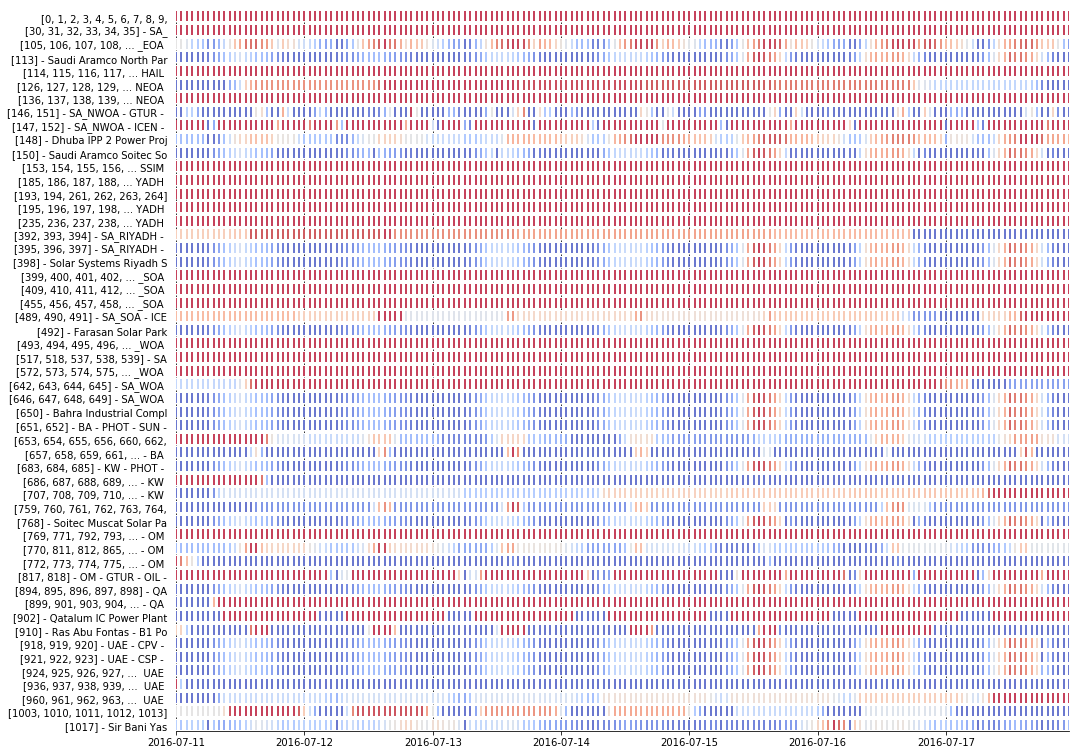

In [23]:
# 'Greys', 'Reds', YlGnBu', 'BuPu', 'YlOrRd', 'cool', 'Wistia', 'coolwarm', 'bwr', 'rainbow', 'jet'
post.plot_rug(results1['UnitOutputPower'], on_off=False, cmap='coolwarm')
#plt.savefig('../../../../../../../Desktop/AAA.png',dpi=300,tight_layout='tight_box')

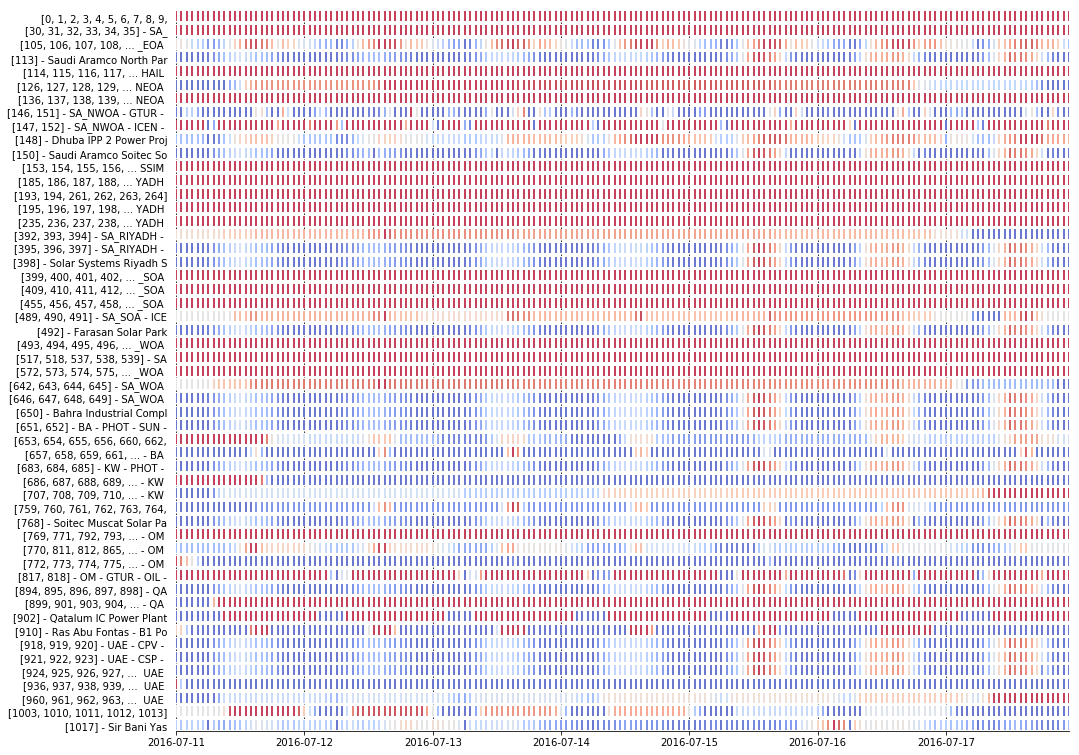

In [24]:
post.plot_rug(results2['UnitOutputPower'], on_off=False, cmap= 'coolwarm')
#plt.savefig('../../../../../../../Desktop/AAA2.png',dpi=300,tight_layout='tight_box')

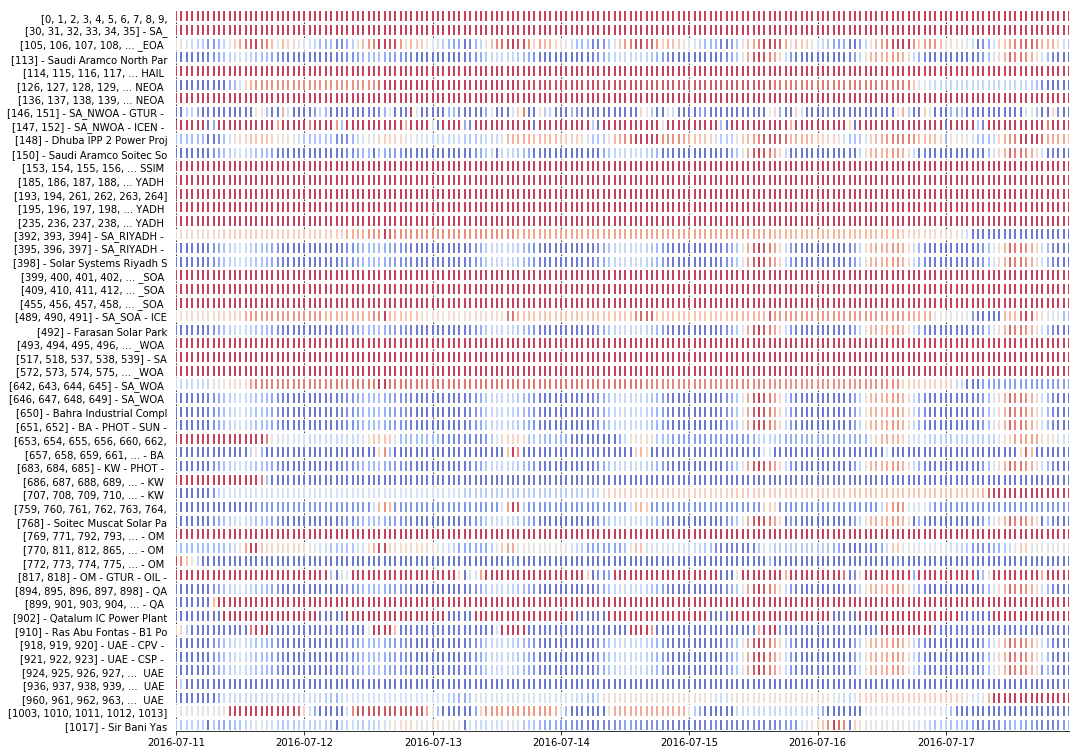

In [25]:
post.plot_rug(results3['UnitOutputPower'], on_off=False, cmap='coolwarm')
#plt.savefig('../../../../../../../Desktop/AAA3.png',dpi=300,tight_layout='tight_box')

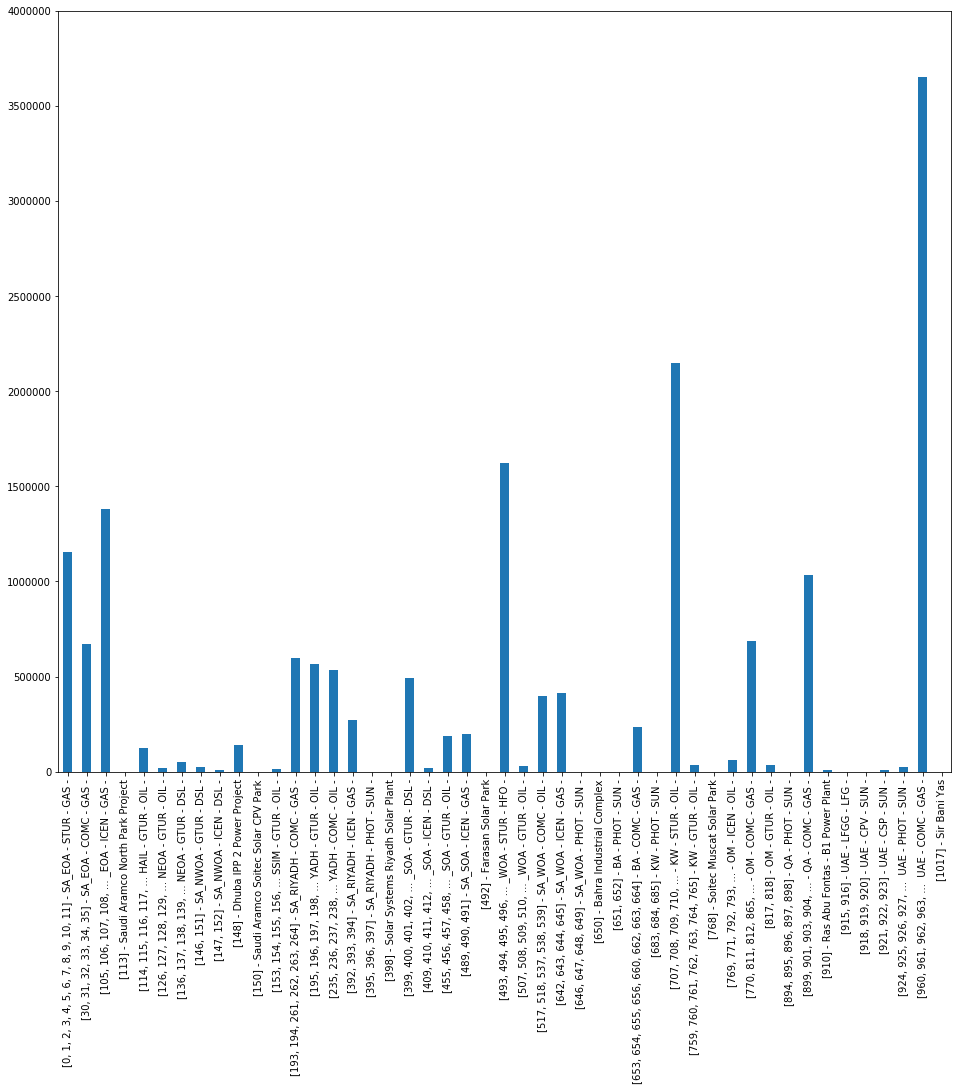

In [44]:
results1['UnitOutputPower'].sum().plot(kind='bar', ylim=(0,4e6))

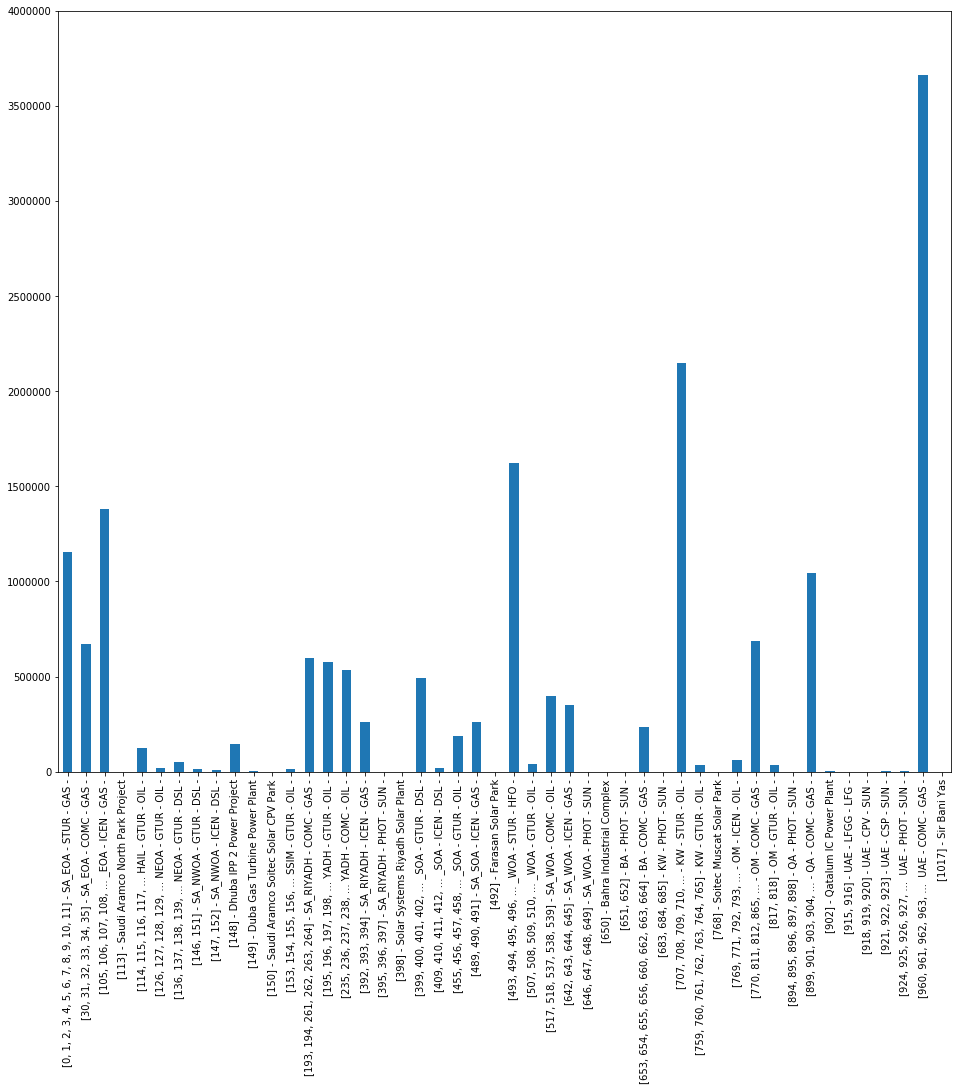

In [45]:
results2['UnitOutputPower'].sum().plot(kind='bar', ylim=(0,4e6))

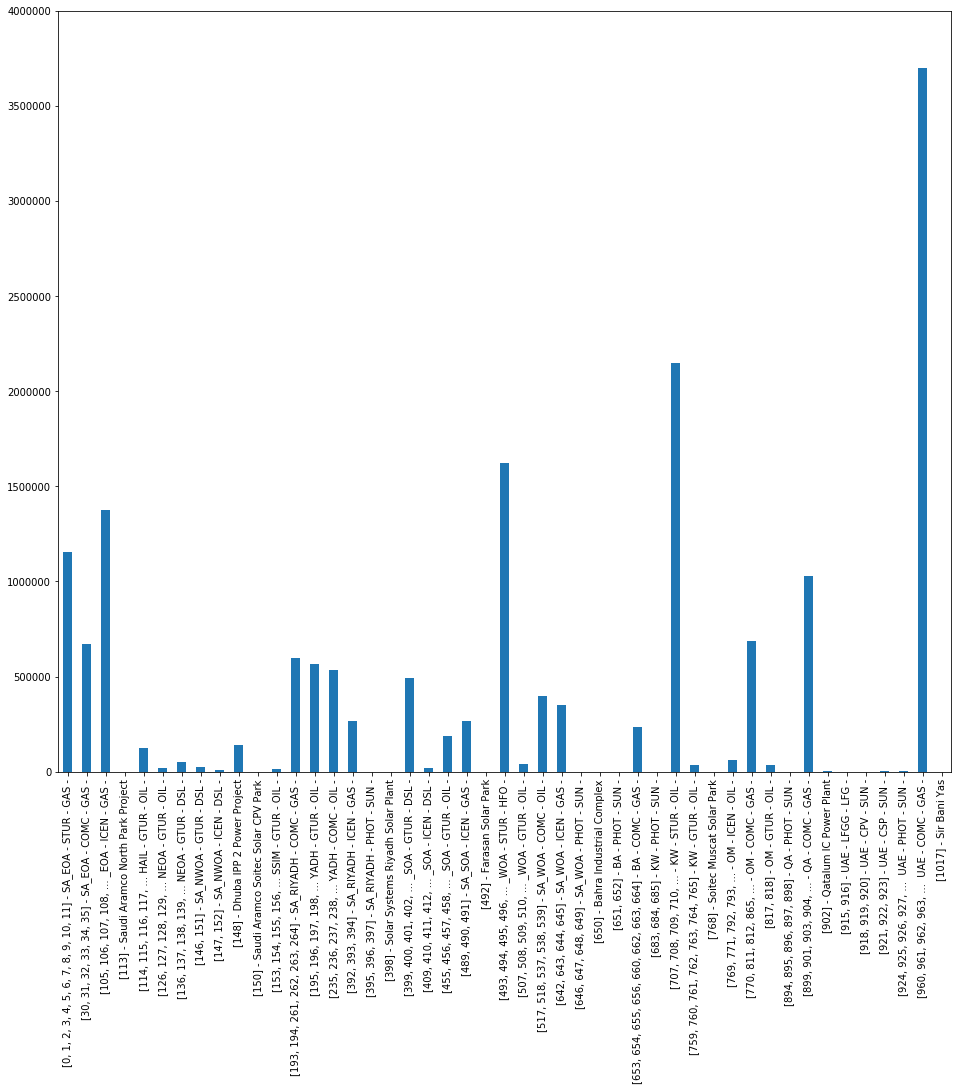

In [46]:
results3['UnitOutputPower'].sum().plot(kind='bar', ylim=(0,4e6))

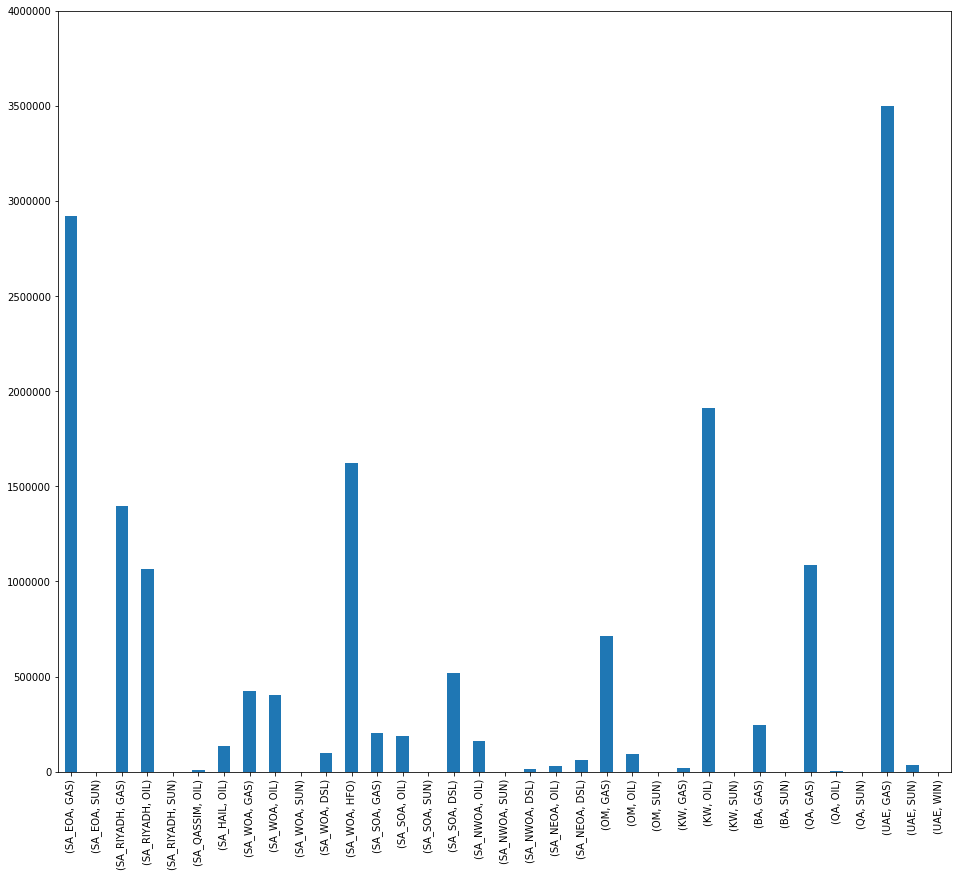

In [26]:
results1['NodeFuelPower'].sum().plot(kind='bar', ylim=(0,4e6))
#plt.savefig('../../../../../../../Desktop/AAA4.png',dpi=300,tight_layout='tight_box')

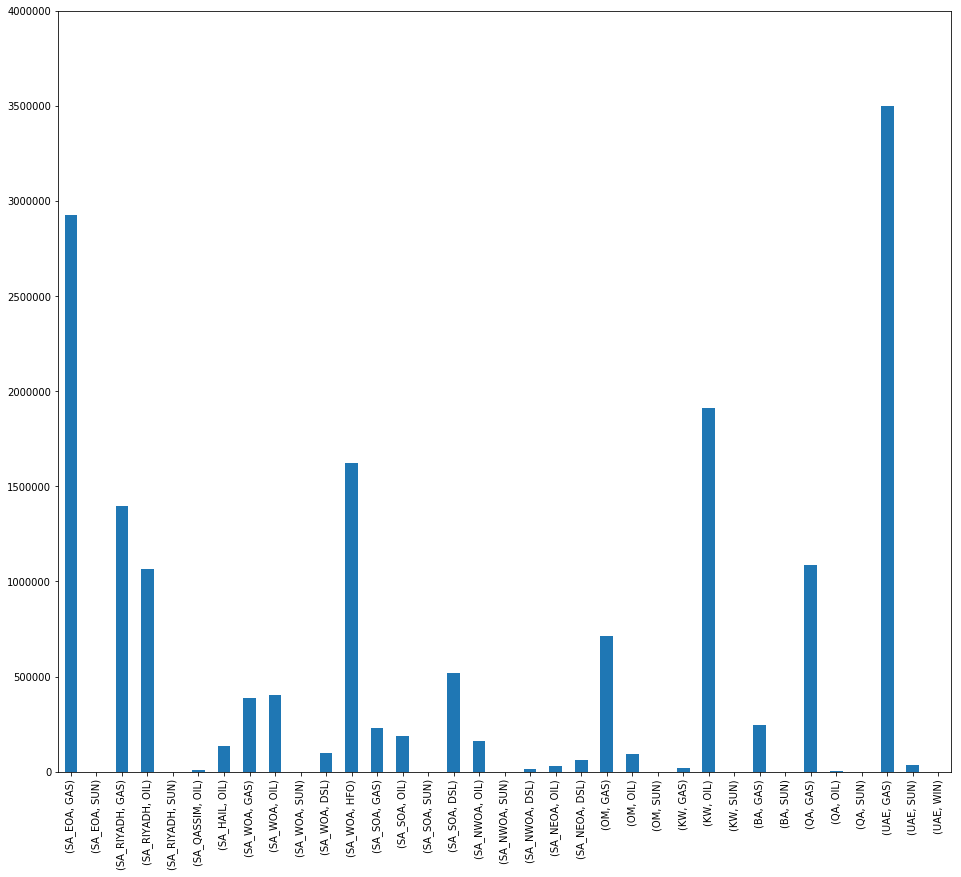

In [27]:
results2['NodeFuelPower'].sum().plot(kind='bar', ylim=(0,4e6))
#plt.savefig('../../../../../../../Desktop/AAA5.png',dpi=300,tight_layout='tight_box')

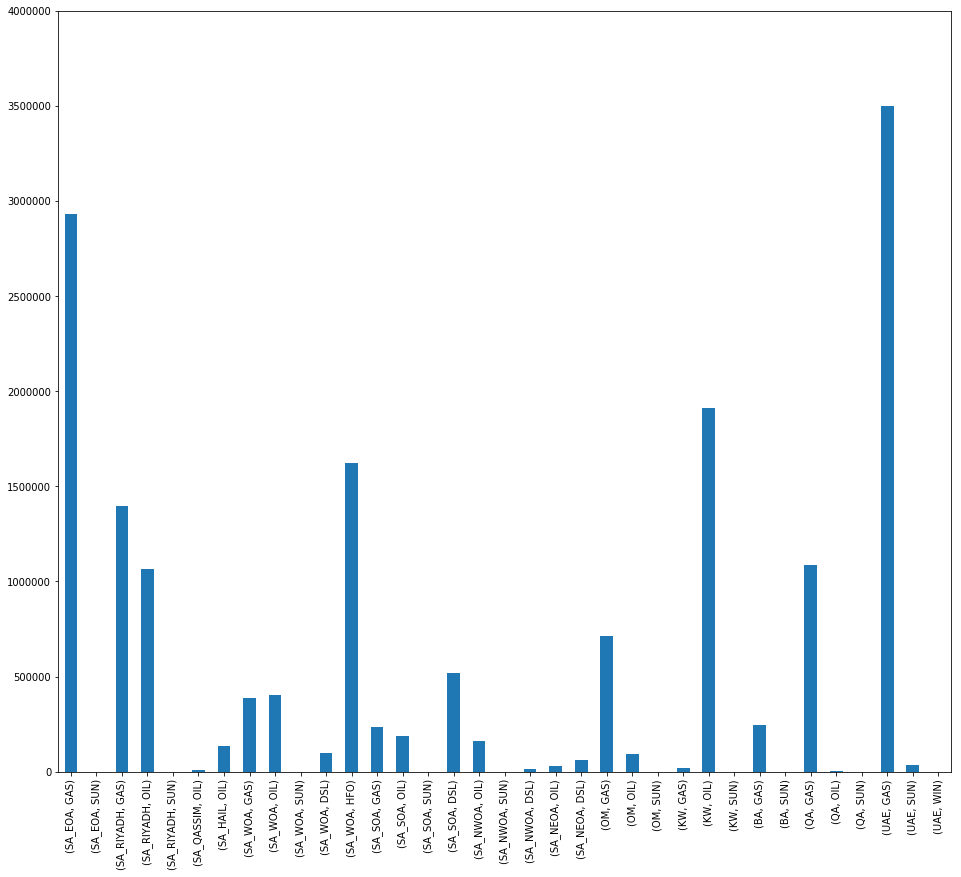

In [28]:
results3['NodeFuelPower'].sum().plot(kind='bar', ylim=(0,4e6))
#plt.savefig('../../../../../../../Desktop/AAA6.png',dpi=300,tight_layout='tight_box')

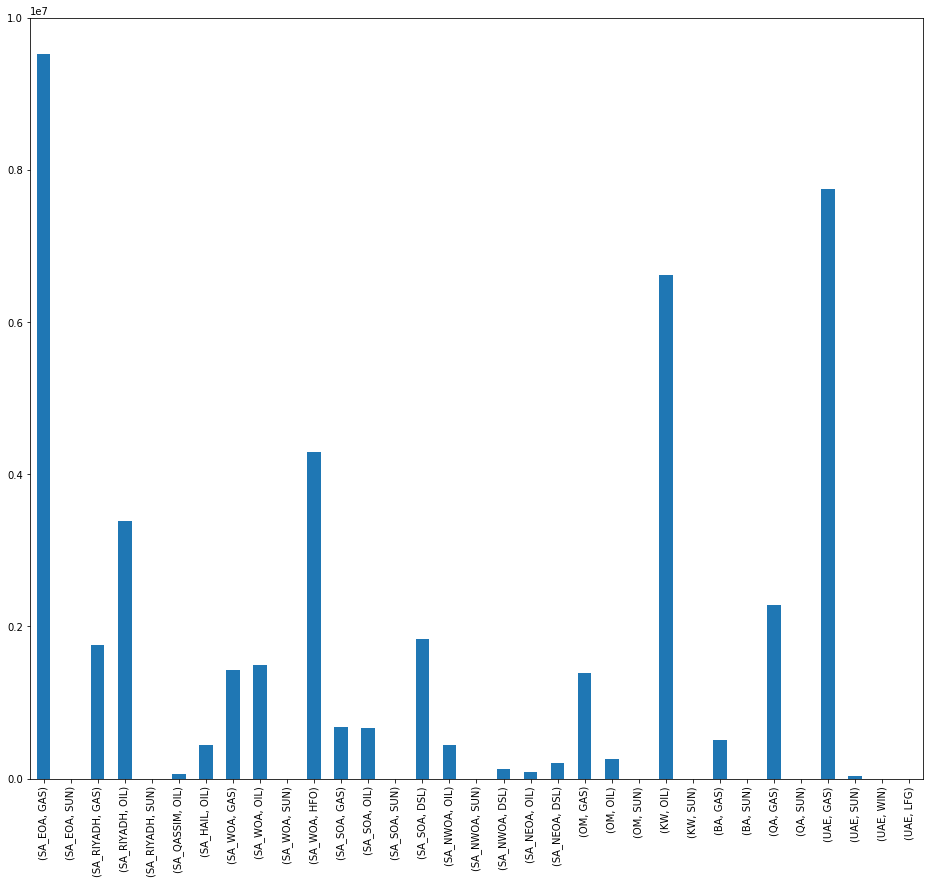

In [61]:
results1['NodeFuelConsumption'].sum().plot(kind='bar', ylim=(0,10e6))

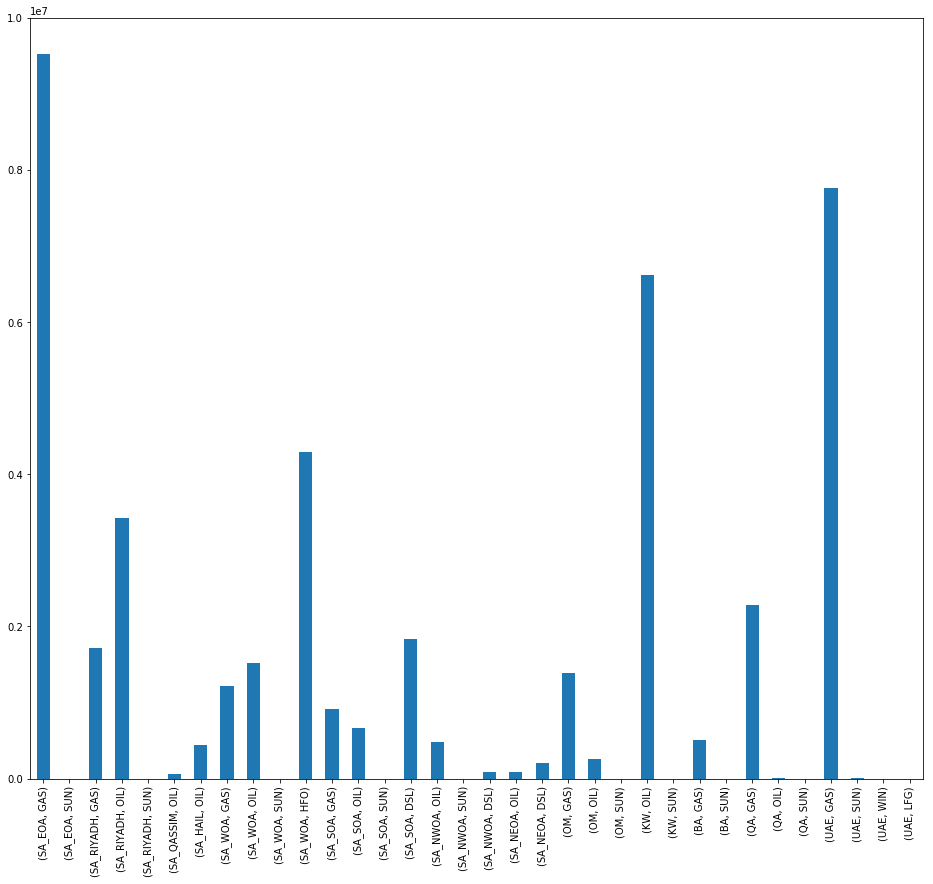

In [62]:
results2['NodeFuelConsumption'].sum().plot(kind='bar', ylim=(0,10e6))

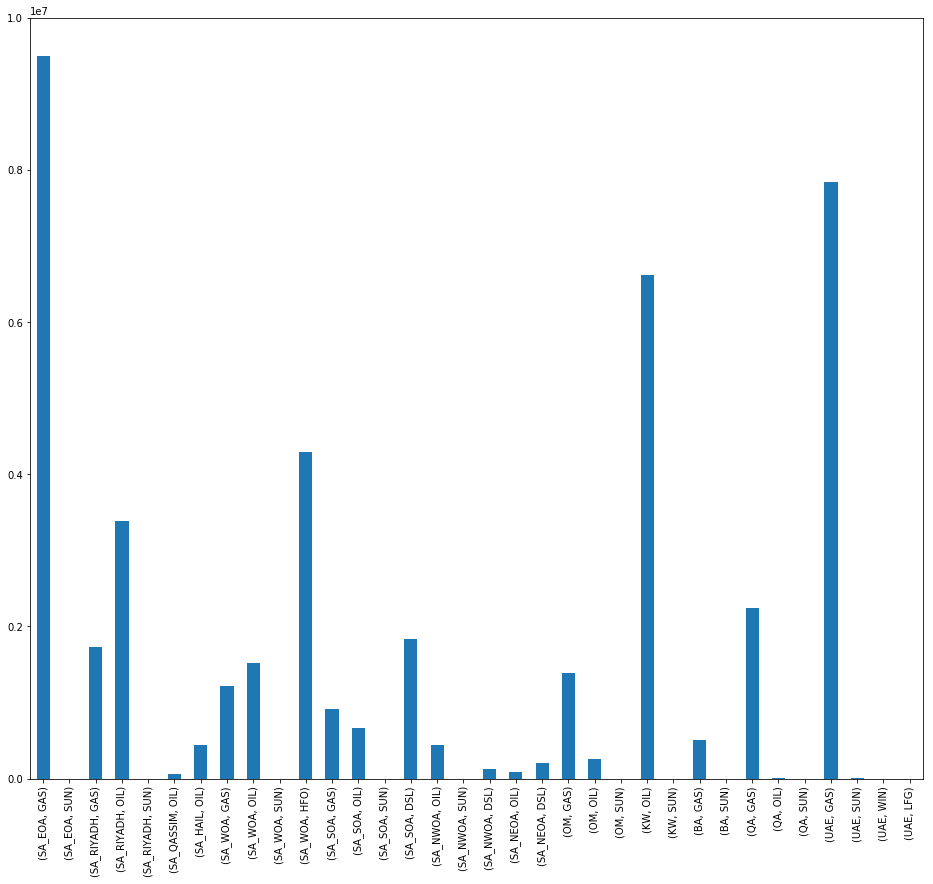

In [63]:
results3['NodeFuelConsumption'].sum().plot(kind='bar', ylim=(0,10e6))

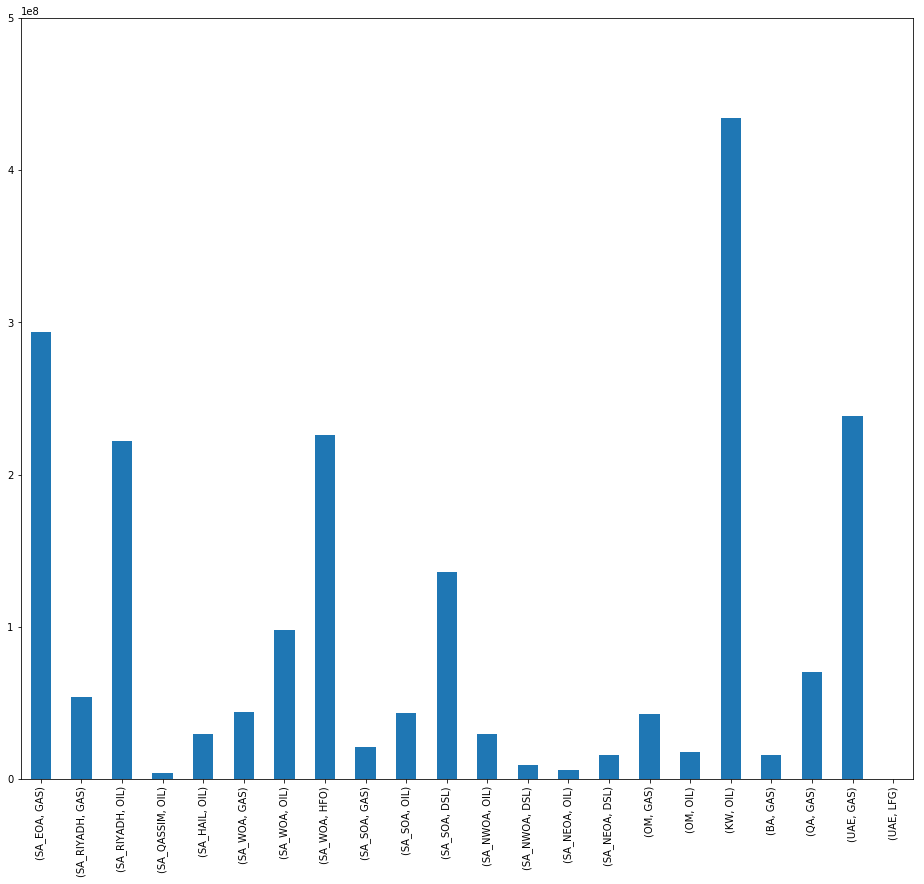

In [64]:
results1['NodeFuelCost'].sum().plot(kind='bar', ylim=(0,5e8))

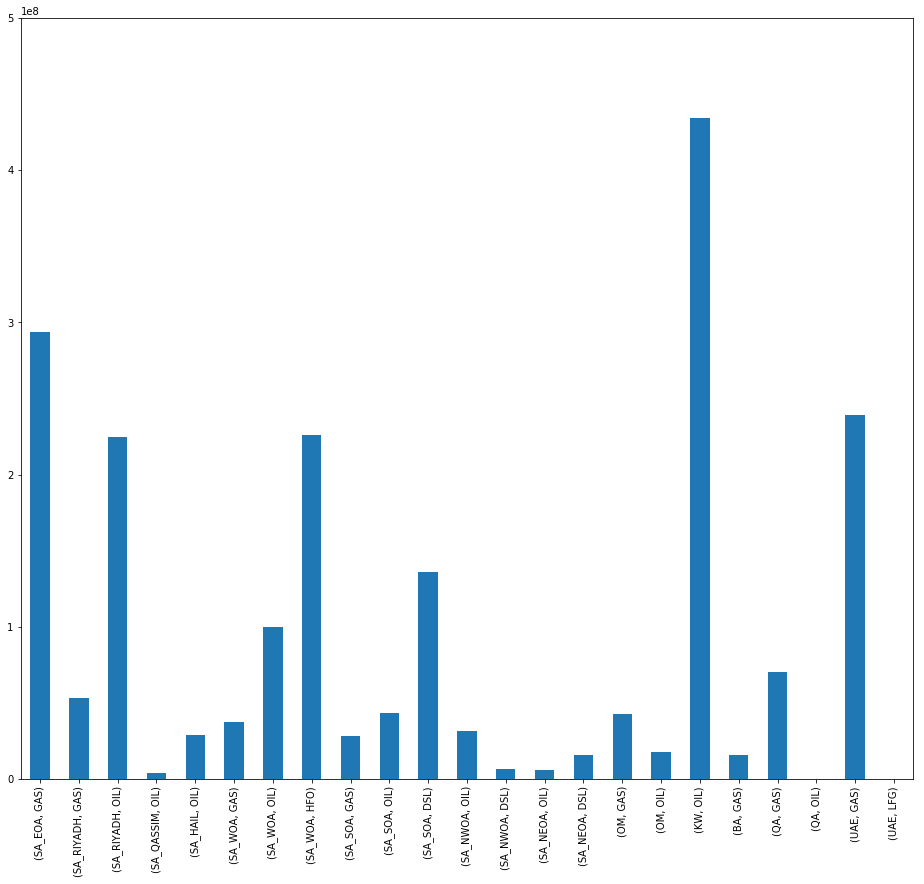

In [65]:
results2['NodeFuelCost'].sum().plot(kind='bar', ylim=(0,5e8))

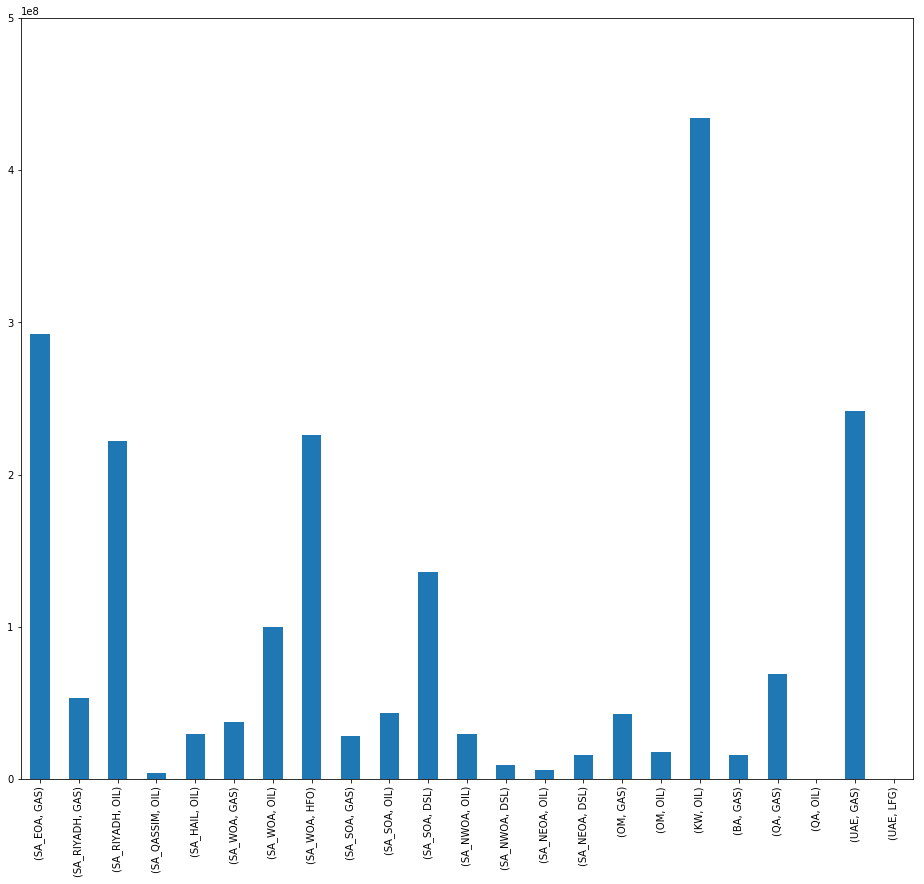

In [66]:
results3['NodeFuelCost'].sum().plot(kind='bar', ylim=(0,5e8))

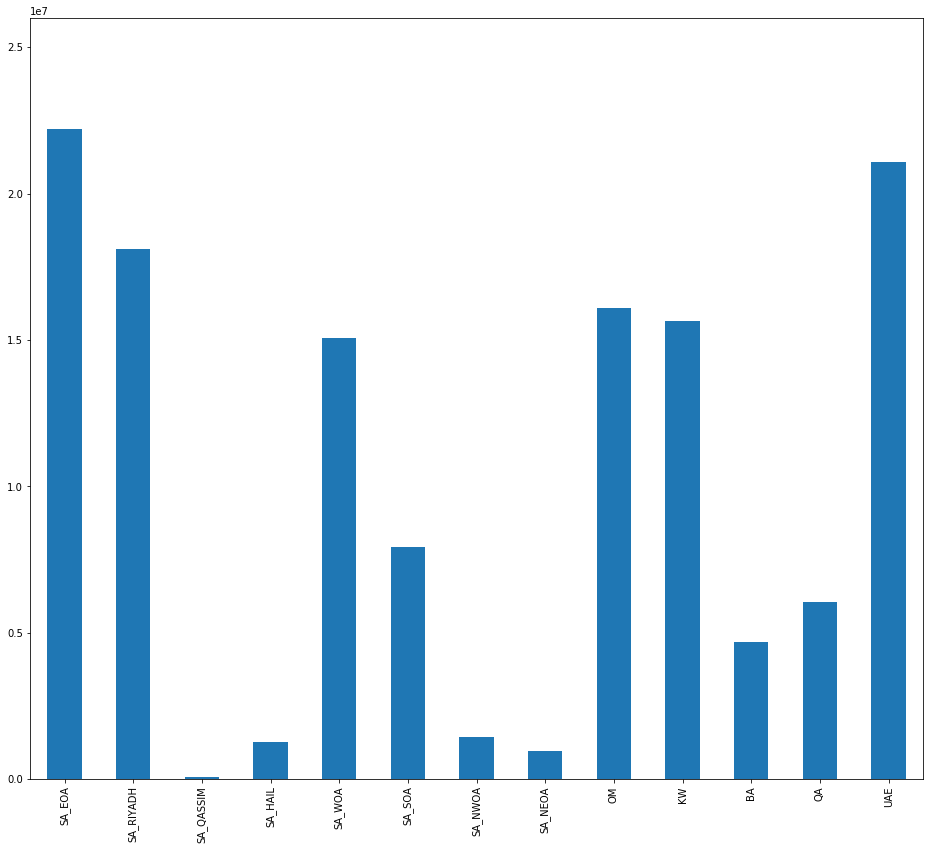

In [29]:
results1['TotalNodeOperationCost'].sum().plot(kind='bar', ylim=(0,2.6e7))
#plt.savefig('../../../../../../../Desktop/AAA7.png',dpi=300,tight_layout='tight_box')

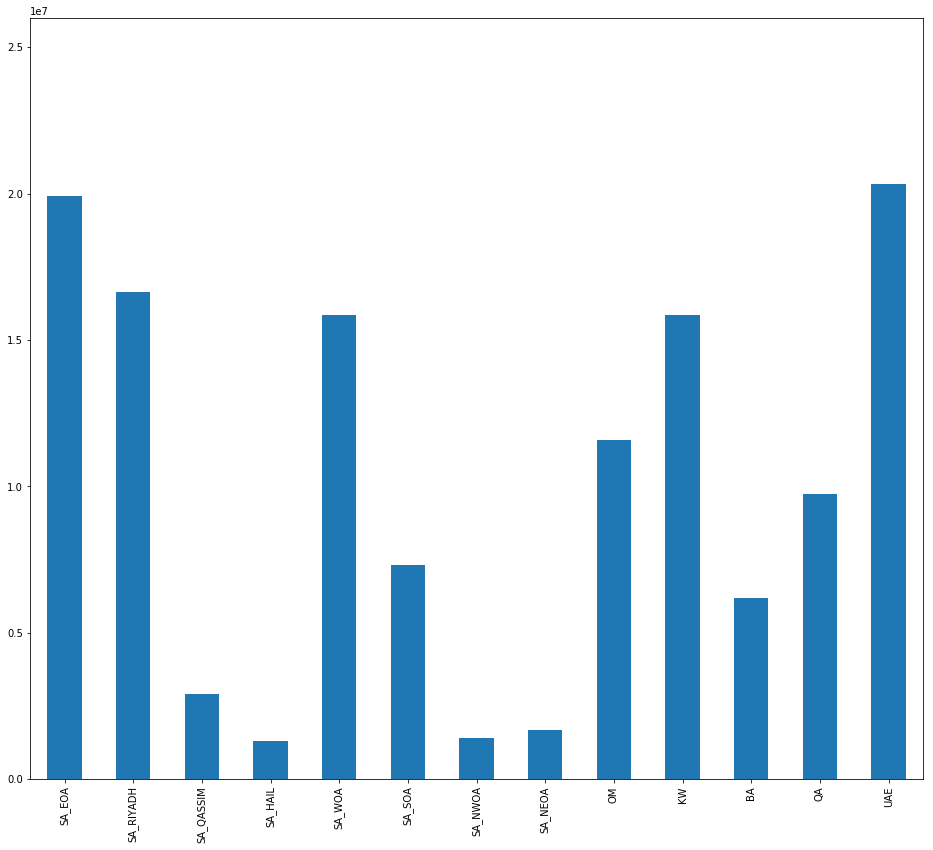

In [30]:
results2['TotalNodeOperationCost'].sum().plot(kind='bar', ylim=(0,2.6e7))
#plt.savefig('../../../../../../../Desktop/AAA8.png',dpi=300,tight_layout='tight_box')

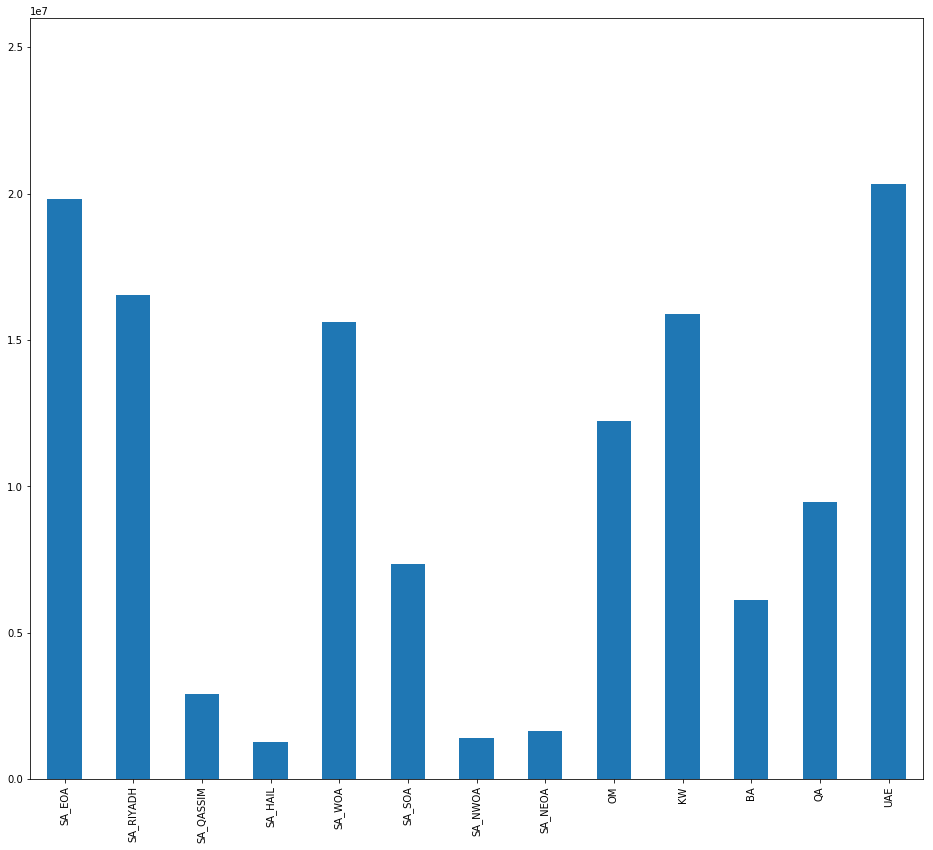

In [31]:
results3['TotalNodeOperationCost'].sum().plot(kind='bar', ylim=(0,2.6e7))
#plt.savefig('../../../../../../../Desktop/AAA9.png',dpi=300,tight_layout='tight_box')

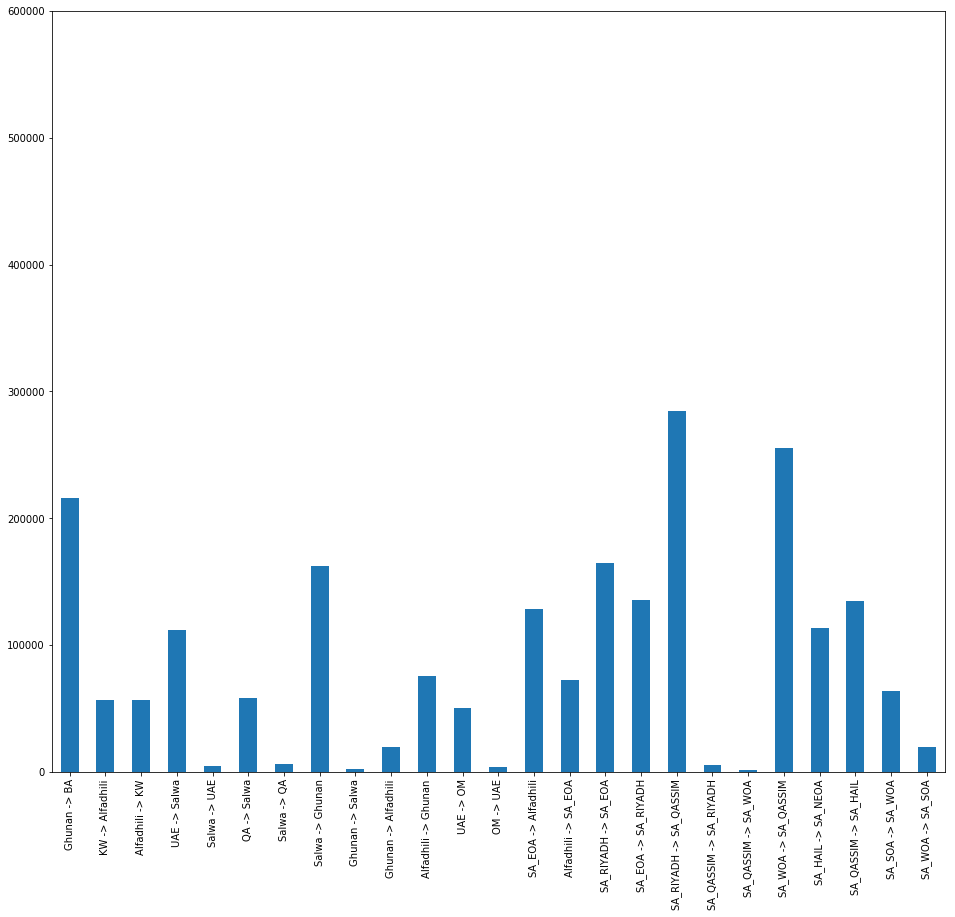

In [32]:
results1['PowerFlow'].sum().plot(kind='bar', ylim=(0,600e3))
#plt.savefig('../../../../../../../Desktop/AAA10.png',dpi=300,tight_layout='tight_box')

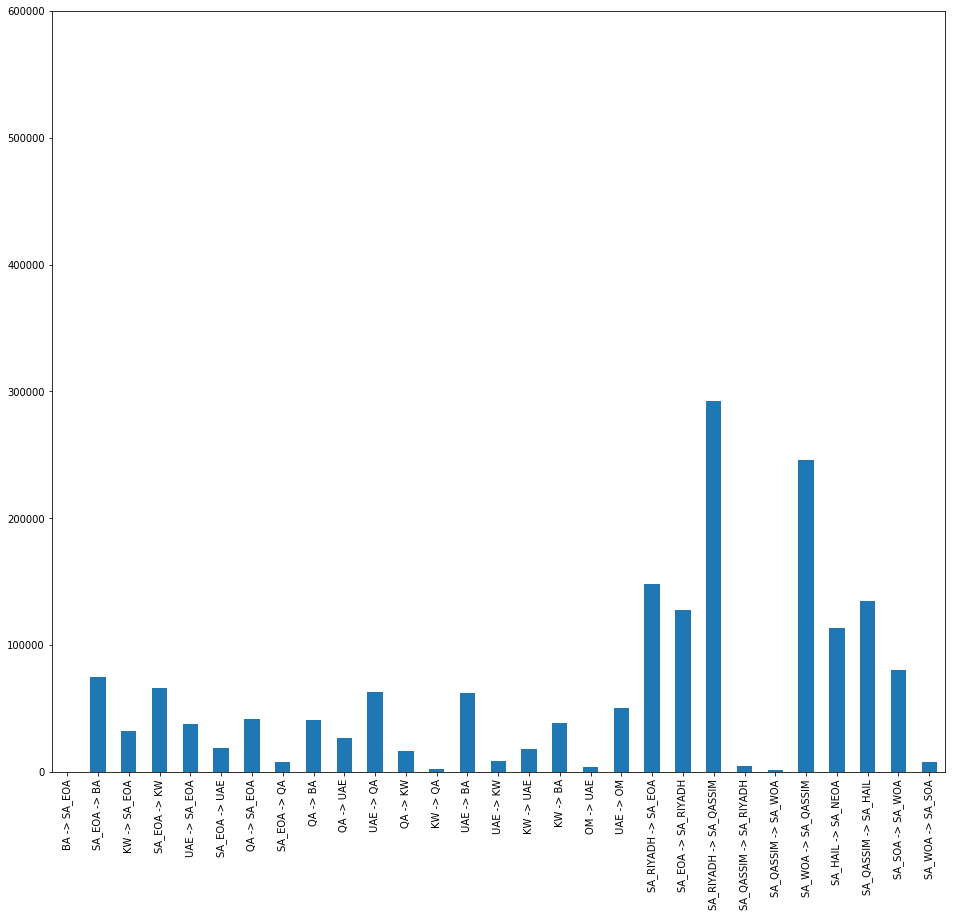

In [33]:
results2['PowerFlow'].sum().plot(kind='bar', ylim=(0,600e3))
#plt.savefig('../../../../../../../Desktop/AAA11.png',dpi=300,tight_layout='tight_box')

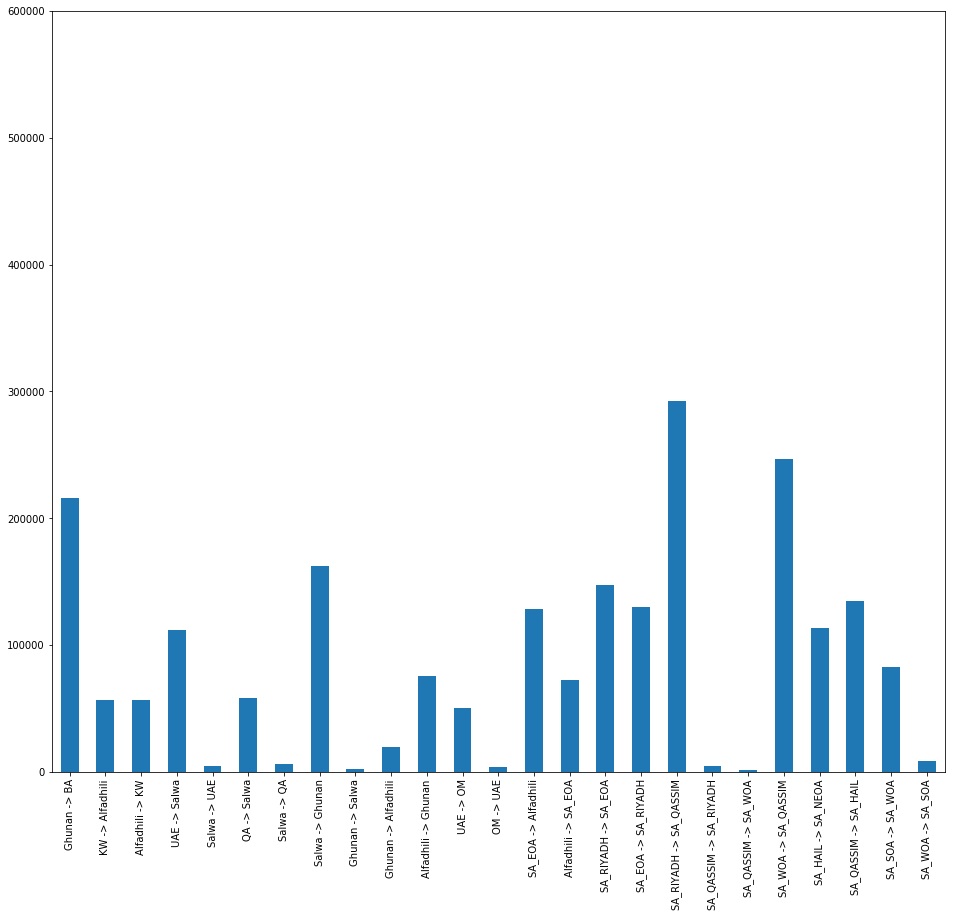

In [34]:
results3['PowerFlow'].sum().plot(kind='bar', ylim=(0,600e3))
#plt.savefig('../../../../../../../Desktop/AAA12.png',dpi=300,tight_layout='tight_box')

In [84]:
zone = 'SA_RIYADH'

NewOutputFlow1 = results1['PowerFlow'].copy()
OriginalColumns = []
reverseindex = []
for j,column in enumerate(NewOutputFlow1):
    A = column.split(' -> ')
    OriginalColumns.append(A)
    B = list(reversed(A))
    if B in OriginalColumns:
        reverseindex.append(j)
        D = [i for i, C in enumerate(OriginalColumns) if C==B]
        D = int(''.join(map(str,D)))
        NewOutputFlow1.iloc[:,D] = NewOutputFlow1.iloc[:,D] - NewOutputFlow1.iloc[:,j]
NewOutputFlow1 = NewOutputFlow1.drop(NewOutputFlow1.columns[reverseindex], axis=1).copy()

total=0
for i in NewOutputFlow1:
    From, To = i.split(' -> ')
    if To==zone:
        total+=NewOutputFlow1[i].sum()
print('Total power flows to node '+zone+' is: '+str(total))

total2=0
for i in NewOutputFlow1:
    From, To = i.split(' -> ')
    if From==zone:
        total2+=NewOutputFlow1[i].sum()
print('Total power flows from node '+zone+' is: '+str(total2))
print('Net power flows to node '+zone+' is: '+str(total-total2))

Total power flows to node SA_RIYADH is: 0
Total power flows from node SA_RIYADH is: 307923.1865715817
Net power flows to node SA_RIYADH is: -307923.1865715817


In [85]:
zone = 'SA_RIYADH'

NewOutputFlow2 = results2['PowerFlow'].copy()
OriginalColumns = []
reverseindex = []
for j,column in enumerate(NewOutputFlow2):
    A = column.split(' -> ')
    OriginalColumns.append(A)
    B = list(reversed(A))
    if B in OriginalColumns:
        reverseindex.append(j)
        D = [i for i, C in enumerate(OriginalColumns) if C==B]
        D = int(''.join(map(str,D)))
        NewOutputFlow2.iloc[:,D] = NewOutputFlow2.iloc[:,D] - NewOutputFlow2.iloc[:,j]
NewOutputFlow2 = NewOutputFlow2.drop(NewOutputFlow2.columns[reverseindex], axis=1).copy()

total=0
for i in NewOutputFlow2:
    From, To = i.split(' -> ')
    if To==zone:
        total+=NewOutputFlow2[i].sum()
print('Total power flows to node '+zone+' is: '+str(total))

total2=0
for i in NewOutputFlow2:
    From, To = i.split(' -> ')
    if From==zone:
        total2+=NewOutputFlow2[i].sum()
print('Total power flows from node '+zone+' is: '+str(total2))
print('Net power flows to node '+zone+' is: '+str(total-total2))

Total power flows to node SA_RIYADH is: 0
Total power flows from node SA_RIYADH is: 308589.64102967933
Net power flows to node SA_RIYADH is: -308589.64102967933


In [86]:
zone = 'SA_RIYADH'

NewOutputFlow3 = results3['PowerFlow'].copy()
OriginalColumns = []
reverseindex = []
for j,column in enumerate(NewOutputFlow3):
    A = column.split(' -> ')
    OriginalColumns.append(A)
    B = list(reversed(A))
    if B in OriginalColumns:
        reverseindex.append(j)
        D = [i for i, C in enumerate(OriginalColumns) if C==B]
        D = int(''.join(map(str,D)))
        NewOutputFlow3.iloc[:,D] = NewOutputFlow3.iloc[:,D] - NewOutputFlow3.iloc[:,j]
NewOutputFlow3 = NewOutputFlow3.drop(NewOutputFlow3.columns[reverseindex], axis=1).copy()

total=0
for i in NewOutputFlow3:
    From, To = i.split(' -> ')
    if To==zone:
        total+=NewOutputFlow3[i].sum()
print('Total power flows to node '+zone+' is: '+str(total))

total2=0
for i in NewOutputFlow3:
    From, To = i.split(' -> ')
    if From==zone:
        total2+=NewOutputFlow3[i].sum()
print('Total power flows from node '+zone+' is: '+str(total2))
print('Net power flows to node '+zone+' is: '+str(total-total2))

Total power flows to node SA_RIYADH is: 0
Total power flows from node SA_RIYADH is: 304742.70823323366
Net power flows to node SA_RIYADH is: -304742.70823323366


In [87]:
results2['NetExportedPower']['SA_EOA'].sum()

35305.86827552036

In [88]:
results3['NetExportedPower']['SA_EOA'].sum()

38459.10327550472

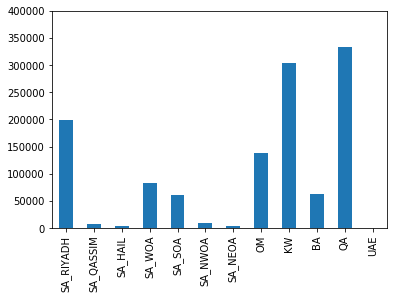

In [41]:
results2['NetExportedPowerToNode']['SA_EOA'].sum().plot(kind='bar', ylim=(0,400e3))

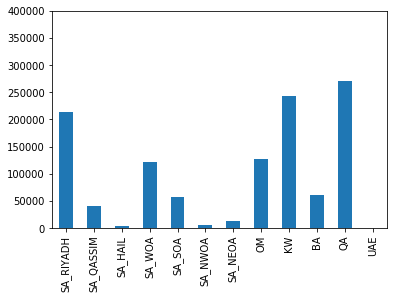

In [101]:
results3['NetExportedPowerToNode']['SA_EOA'].sum().plot(kind='bar', ylim=(0,400e3))

-327564.80385268875